## Import Package

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, RocCurveDisplay
)
from sklearn.preprocessing import LabelBinarizer
import missingno as msno
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

## Data Generating Process

In [183]:
np.random.seed(42)

# --- Settings ---
n_samples = 14600
ore_types = ['Sulphide', 'Oxide', 'Mixed']

nan_fraction = 0.05
outlier_fraction = 0.03
duplicate_fraction = 0.03
noise_scale = 0.15
random_perturb_fraction = 0.15

numeric_features = ['depth_mean','fe_pct','cu_pct','sio2_pct','moisture_pct','au_gpt']

# --- Helper function ---
def sample_with_noise_overlap(low, high, overlap_low=None, overlap_high=None, noise_scale=noise_scale):
    val = np.random.uniform(low, high)
    noise = np.random.normal(0, (high - low) * noise_scale)
    val += noise
    if overlap_low is not None and overlap_high is not None:
        val += np.random.uniform(overlap_low, overlap_high)
    return val

# --- Generate ore types ---
ore_type_label = np.random.choice(ore_types, n_samples)
dataset = pd.DataFrame({'ore_type_label': ore_type_label})

# --- Conditional sampling ---
dataset['depth_mean'] = [
    sample_with_noise_overlap(20,50,-5,5) if t=='Sulphide' else
    sample_with_noise_overlap(0,25,-5,5) if t=='Oxide' else
    sample_with_noise_overlap(10,40,-5,5)
    for t in ore_type_label
]

dataset['fe_pct'] = [
    sample_with_noise_overlap(45,60,-5,5) if t=='Sulphide' else
    sample_with_noise_overlap(20,40,-5,5) if t=='Oxide' else
    sample_with_noise_overlap(30,55,-5,5)
    for t in ore_type_label
]

dataset['cu_pct'] = [
    sample_with_noise_overlap(1.0,1.5,-0.2,0.2) if t=='Sulphide' else
    sample_with_noise_overlap(0.3,0.8,-0.2,0.2) if t=='Oxide' else
    sample_with_noise_overlap(0.5,1.2,-0.2,0.2)
    for t in ore_type_label
]

dataset['sio2_pct'] = [
    sample_with_noise_overlap(0,2,-0.5,0.5) if t=='Sulphide' else
    sample_with_noise_overlap(3,5,-0.5,0.5) if t=='Oxide' else
    sample_with_noise_overlap(1,4,-0.5,0.5)
    for t in ore_type_label
]

dataset['moisture_pct'] = [
    sample_with_noise_overlap(0,1,-0.3,0.3) if t=='Sulphide' else
    sample_with_noise_overlap(1,3,-0.3,0.3) if t=='Oxide' else
    sample_with_noise_overlap(0.5,2,-0.3,0.3)
    for t in ore_type_label
]

dataset['au_gpt'] = [
    sample_with_noise_overlap(1,2,-0.3,0.3) if t=='Sulphide' else
    sample_with_noise_overlap(0,0.5,-0.3,0.3) if t=='Oxide' else
    sample_with_noise_overlap(0.3,1.2,-0.3,0.3)
    for t in ore_type_label
]

# --- Random pit assignment and sample_id ---
dataset['pit'] = np.random.choice(['PitA','PitB','PitC'], n_samples)
dataset['sample_id'] = [f'S{i:04d}' for i in range(n_samples)]

# --- Introduce NaN values ---
for col in numeric_features:
    nan_indices = np.random.choice(dataset.index, size=int(n_samples*nan_fraction), replace=False)
    dataset.loc[nan_indices, col] = np.nan

# --- Introduce outliers ---
feature_scales = {'depth_mean':100, 'fe_pct':200, 'cu_pct':5, 'sio2_pct':20, 'moisture_pct':10, 'au_gpt':10}
for col, scale in feature_scales.items():
    outlier_indices = np.random.choice(dataset.index, size=int(n_samples*outlier_fraction), replace=False)
    dataset.loc[outlier_indices, col] += np.random.uniform(scale, scale*2, len(outlier_indices))

# --- Random perturbation ---
perturb_indices = np.random.choice(dataset.index, size=int(n_samples*random_perturb_fraction), replace=False)
for col in numeric_features:
    val_range = dataset[col].max() - dataset[col].min()
    dataset.loc[perturb_indices, col] += np.random.uniform(-0.3*val_range, 0.3*val_range, len(perturb_indices))

# --- Duplicated rows ---
dup_indices = np.random.choice(dataset.index, size=int(n_samples*duplicate_fraction), replace=False)
dataset = pd.concat([dataset, dataset.loc[dup_indices]], ignore_index=True)

# --- Clip negative values to zero ---
dataset[numeric_features] = dataset[numeric_features].clip(lower=0)

# --- Shuffle dataset ---
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# --- Data Cleaning: Ensure No Negative or Unrealistic Values ---
for col in numeric_features:
    # Set negatif jadi NaN (lebih aman untuk imputasi selanjutnya)
    dataset.loc[dataset[col] < 0, col] = np.nan

# Batasi Fe_pct maksimal 100%
dataset.loc[dataset['fe_pct'] > 100, 'fe_pct'] = 92.0  # Batas wajar Fe maksimal

# Jika ada kolom persen lain, batasi juga secara wajar
for col in ['moisture_pct', 'sio2_pct']:
    dataset.loc[dataset[col] > 100, col] = 100

# Jika ada nilai ekstrem untuk gold (Au_gpt) yang tak realistis
dataset.loc[dataset['au_gpt'] > 50, 'au_gpt'] = np.nan  # 50 g/t batas tinggi wajar
dataset.loc[dataset['au_gpt'] < 0, 'au_gpt'] = np.nan

# Re-shuffle setelah cleaning
dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# --- Validasi akhir ---
print("\n=== Validation Check ===")
print("Negative values remaining per column:")
print((dataset[numeric_features] < 0).sum())

print("\nFe_pct > 100 count:", (dataset['fe_pct'] > 100).sum())
print("\nDescribe after cleaning:")
print(dataset[numeric_features].describe())

# --- Preview ---
dataset.sample(10)

# --- Generate date column per 20 sample ---
n_samples = len(dataset)
samples_per_day = 20
n_days = int(np.ceil(n_samples / samples_per_day))

date_range = pd.date_range(start='2023-01-01', periods=n_days, freq='D')

# Repeat each date for 20 samples
dates = np.repeat(date_range, samples_per_day)

# If dataset longer than dates (due to ceil), trim
dates = dates[:n_samples]

dataset['date'] = dates

# Optional: sort by date for clarity
dataset = dataset.sort_values(['date','pit','sample_id']).reset_index(drop=True)

# Tandai weekend
dataset['is_weekend'] = dataset['date'].dt.dayofweek >= 5  # 5=Saturday,6=Sunday

# Tandai maintenance simulasi
maintenance_dates = pd.to_datetime(['2023-02-15','2023-07-01','2023-12-25'])
dataset['is_maintenance'] = dataset['date'].isin(maintenance_dates)

def adjust_for_holiday(row):
    if row['is_weekend'] or row['is_maintenance']:
        # 20% chance ubah sulphide jadi oxide
        if row['ore_type_label'] == 'Sulphide' and np.random.rand() < 0.2:
            return 'Oxide'
    return row['ore_type_label']

dataset['ore_type_label'] = dataset.apply(adjust_for_holiday, axis=1)

#dataset = dataset[dataset['date']<'2025-01-01'].head(100)
dataset.head()


=== Validation Check ===
Negative values remaining per column:
depth_mean      0
fe_pct          0
cu_pct          0
sio2_pct        0
moisture_pct    0
au_gpt          0
dtype: int64

Fe_pct > 100 count: 0

Describe after cleaning:
         depth_mean        fe_pct        cu_pct      sio2_pct  moisture_pct   
count  14292.000000  14283.000000  14284.000000  14287.000000  14285.000000  \
mean      30.395353     43.676547      1.187514      3.760252      1.878063   
std       31.791173     20.588892      1.492360      5.838609      2.915142   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       13.692520     31.219452      0.568546      1.130558      0.564519   
50%       24.737178     43.408641      0.893741      2.586390      1.181371   
75%       37.006151     53.443776      1.249135      4.029140      2.031070   
max      271.308232     99.998774     13.533613     52.489703     25.523635   

             au_gpt  
count  14286.000000  
mean      

ore_type_label  depth_mean     fe_pct    cu_pct  sio2_pct  moisture_pct   
0          Mixed   44.699219  62.639571  0.951984  3.052009      0.707239  \
1          Oxide   14.581044  29.357430       NaN  3.299533     14.359676   
2       Sulphide   48.682659  45.252816       NaN  1.219246      0.414094   
3       Sulphide   35.551886  49.352947  1.582760  0.000000      0.000000   
4       Sulphide   59.499809  54.007629  1.186806  0.768758      0.872558   

     au_gpt   pit sample_id       date  is_weekend  is_maintenance  
0  0.826032  PitA     S0700 2023-01-01        True           False  
1  0.319814  PitA    S11681 2023-01-01        True           False  
2  1.389896  PitA     S5060 2023-01-01        True           False  
3  1.785372  PitA     S5252 2023-01-01        True           False  
4  1.375258  PitA     S7029 2023-01-01        True           False

In [209]:
dataset.to_csv('ore_type_data.csv', index=False)

In [8]:
dataset = pd.read_csv('data/ore_type_data.csv', parse_dates=['date'])

## Exploratory Data Analysis

Train shape: (12030, 12), Test shape: (3008, 12)
Train ore type distribution:
ore_type_label
Oxide       0.350208
Mixed       0.327265
Sulphide    0.322527
Name: proportion, dtype: float64

=== Train Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 12030 entries, 5503 to 522
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ore_type_label  12030 non-null  object        
 1   depth_mean      11434 non-null  float64       
 2   fe_pct          11425 non-null  float64       
 3   cu_pct          11419 non-null  float64       
 4   sio2_pct        11435 non-null  float64       
 5   moisture_pct    11452 non-null  float64       
 6   au_gpt          11434 non-null  float64       
 7   pit             12030 non-null  object        
 8   sample_id       12030 non-null  object        
 9   date            12030 non-null  datetime64[ns]
 10  is_weekend      12030 non-null  bool          
 1

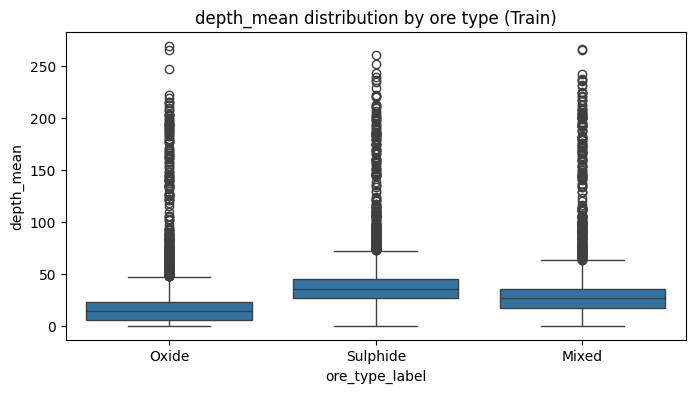

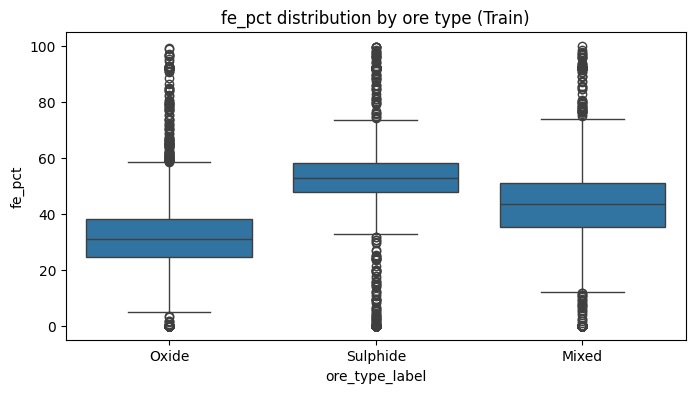

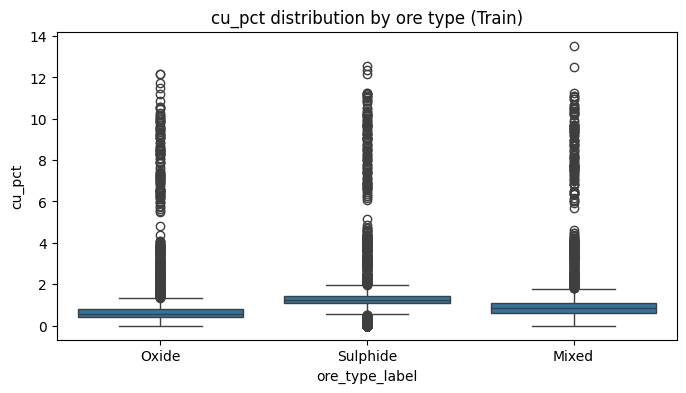

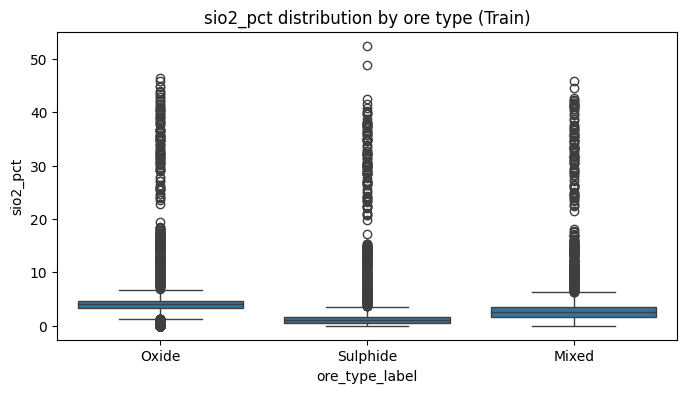

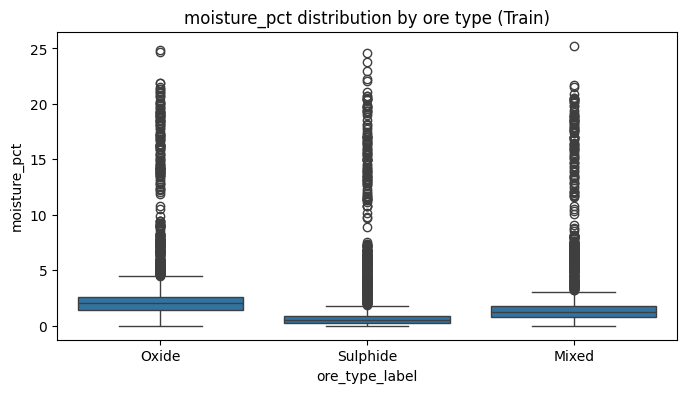

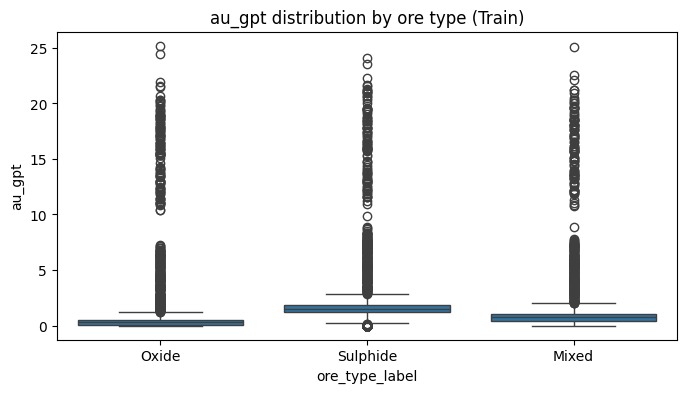

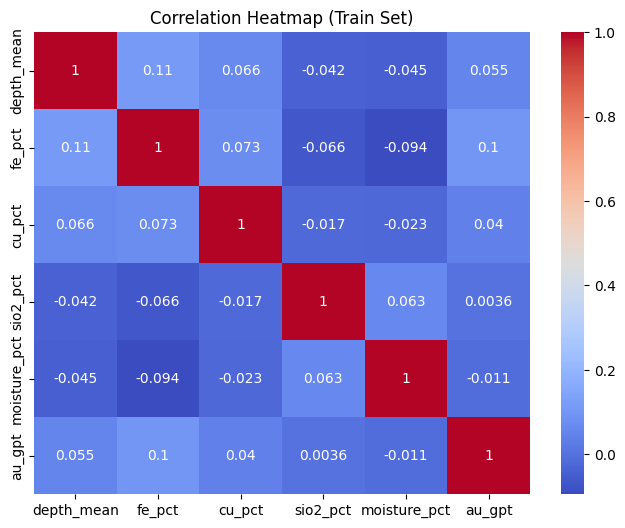


=== Missing Values (Train Set) ===
ore_type_label      0
depth_mean        596
fe_pct            605
cu_pct            611
sio2_pct          595
moisture_pct      578
au_gpt            596
pit                 0
sample_id           0
date                0
is_weekend          0
is_maintenance      0
dtype: int64

Number of duplicate rows in train set: 1


In [184]:
# =========================
# 0. Train/Test Split
# =========================

# Use stratify on ore_type_label to maintain class distribution

train_df, test_df = train_test_split(
                    dataset, test_size=0.2, random_state=42, stratify=dataset['ore_type_label']
                    )

print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
print("Train ore type distribution:")
print(train_df['ore_type_label'].value_counts(normalize=True))

# =========================
# 1. EDA on Train Set
# =========================

print("\n=== Train Dataset Info ===")
train_df.info()

print("\n=== Train Dataset Description ===")
train_df.describe(include='all')

print("\n=== Ore type counts (Train) ===")
train_df['ore_type_label'].value_counts()

# Visualisasi distribusi numeric features per ore type
numeric_features = ['depth_mean','fe_pct','cu_pct','sio2_pct','moisture_pct','au_gpt']

for col in numeric_features:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='ore_type_label', y=col, data=train_df)
    plt.title(f'{col} distribution by ore type (Train)')
    plt.show()

# Correlation heatmap for numeric features in train set
plt.figure(figsize=(8,6))
sns.heatmap(train_df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Train Set)')
plt.show()

# Check missing values in train set
print("\n=== Missing Values (Train Set) ===")
print(train_df.isna().sum())

# Check duplicates in train set
n_duplicates_train = train_df.duplicated().sum()
print(f"\nNumber of duplicate rows in train set: {n_duplicates_train}")


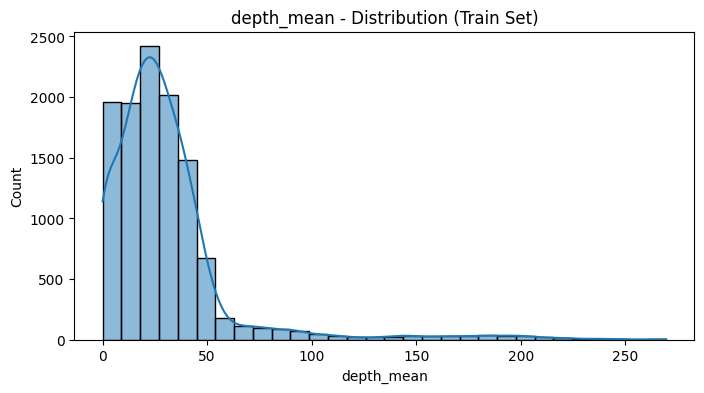

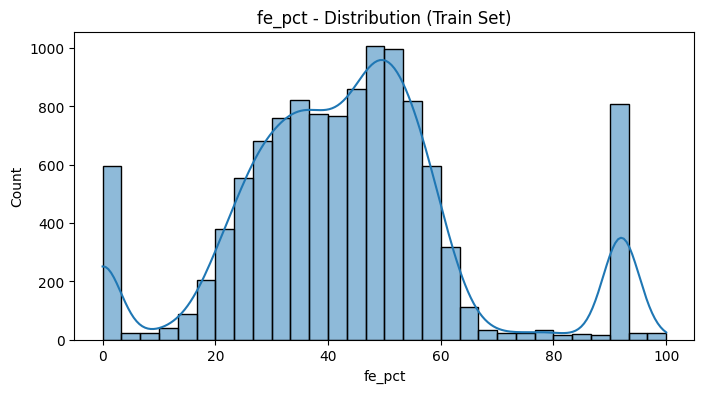

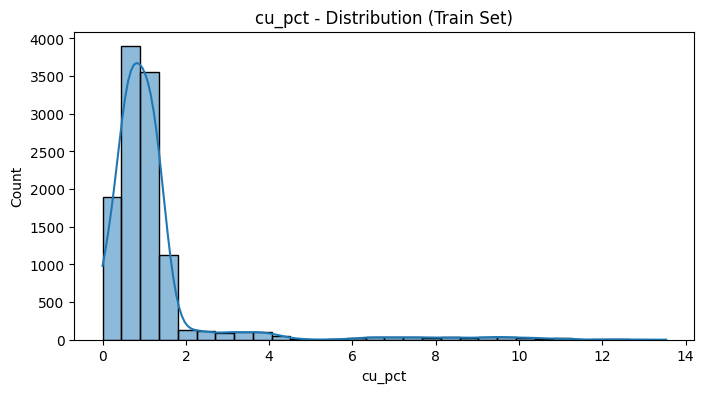

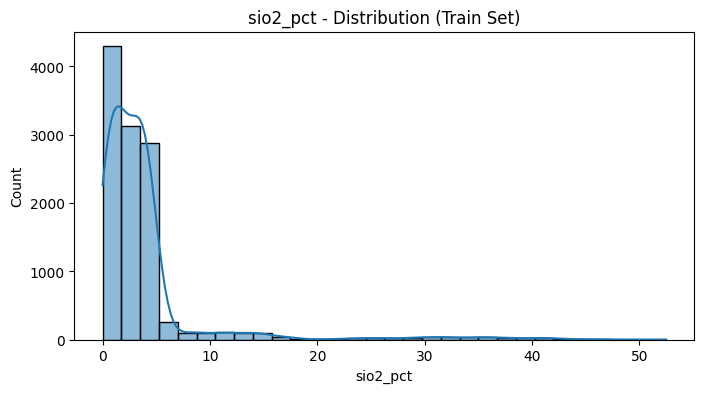

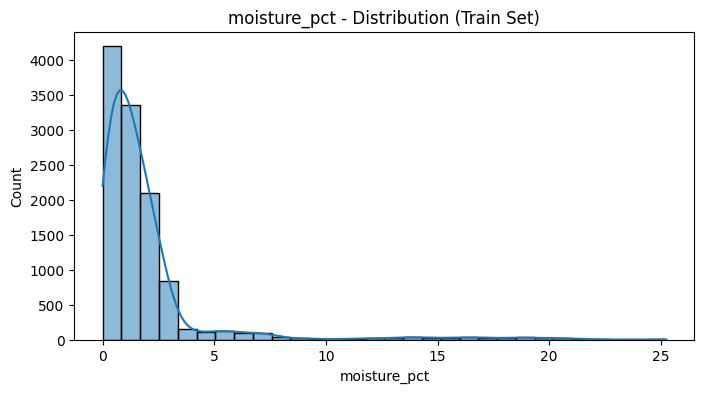

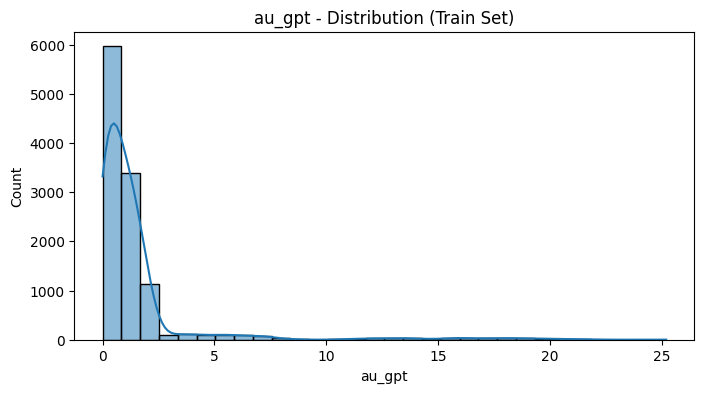


=== Outlier Counts per Feature ===
        Feature  Outlier_Count
5        au_gpt            868
1        fe_pct            866
2        cu_pct            813
4  moisture_pct            812
3      sio2_pct            806
0    depth_mean            650


In [185]:
# Distribution plots for numerical features
for col in numeric_features:
    plt.figure(figsize=(8,4))
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f'{col} - Distribution (Train Set)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# Outlier detection using IQR
outlier_summary = {}
for col in numeric_features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = train_df[(train_df[col] < (Q1 - 1.5 * IQR)) | (train_df[col] > (Q3 + 1.5 * IQR))]
    outlier_summary[col] = len(outliers)
outlier_df = pd.DataFrame(list(outlier_summary.items()), columns=['Feature', 'Outlier_Count'])
print("\n=== Outlier Counts per Feature ===")
print(outlier_df.sort_values(by='Outlier_Count', ascending=False))


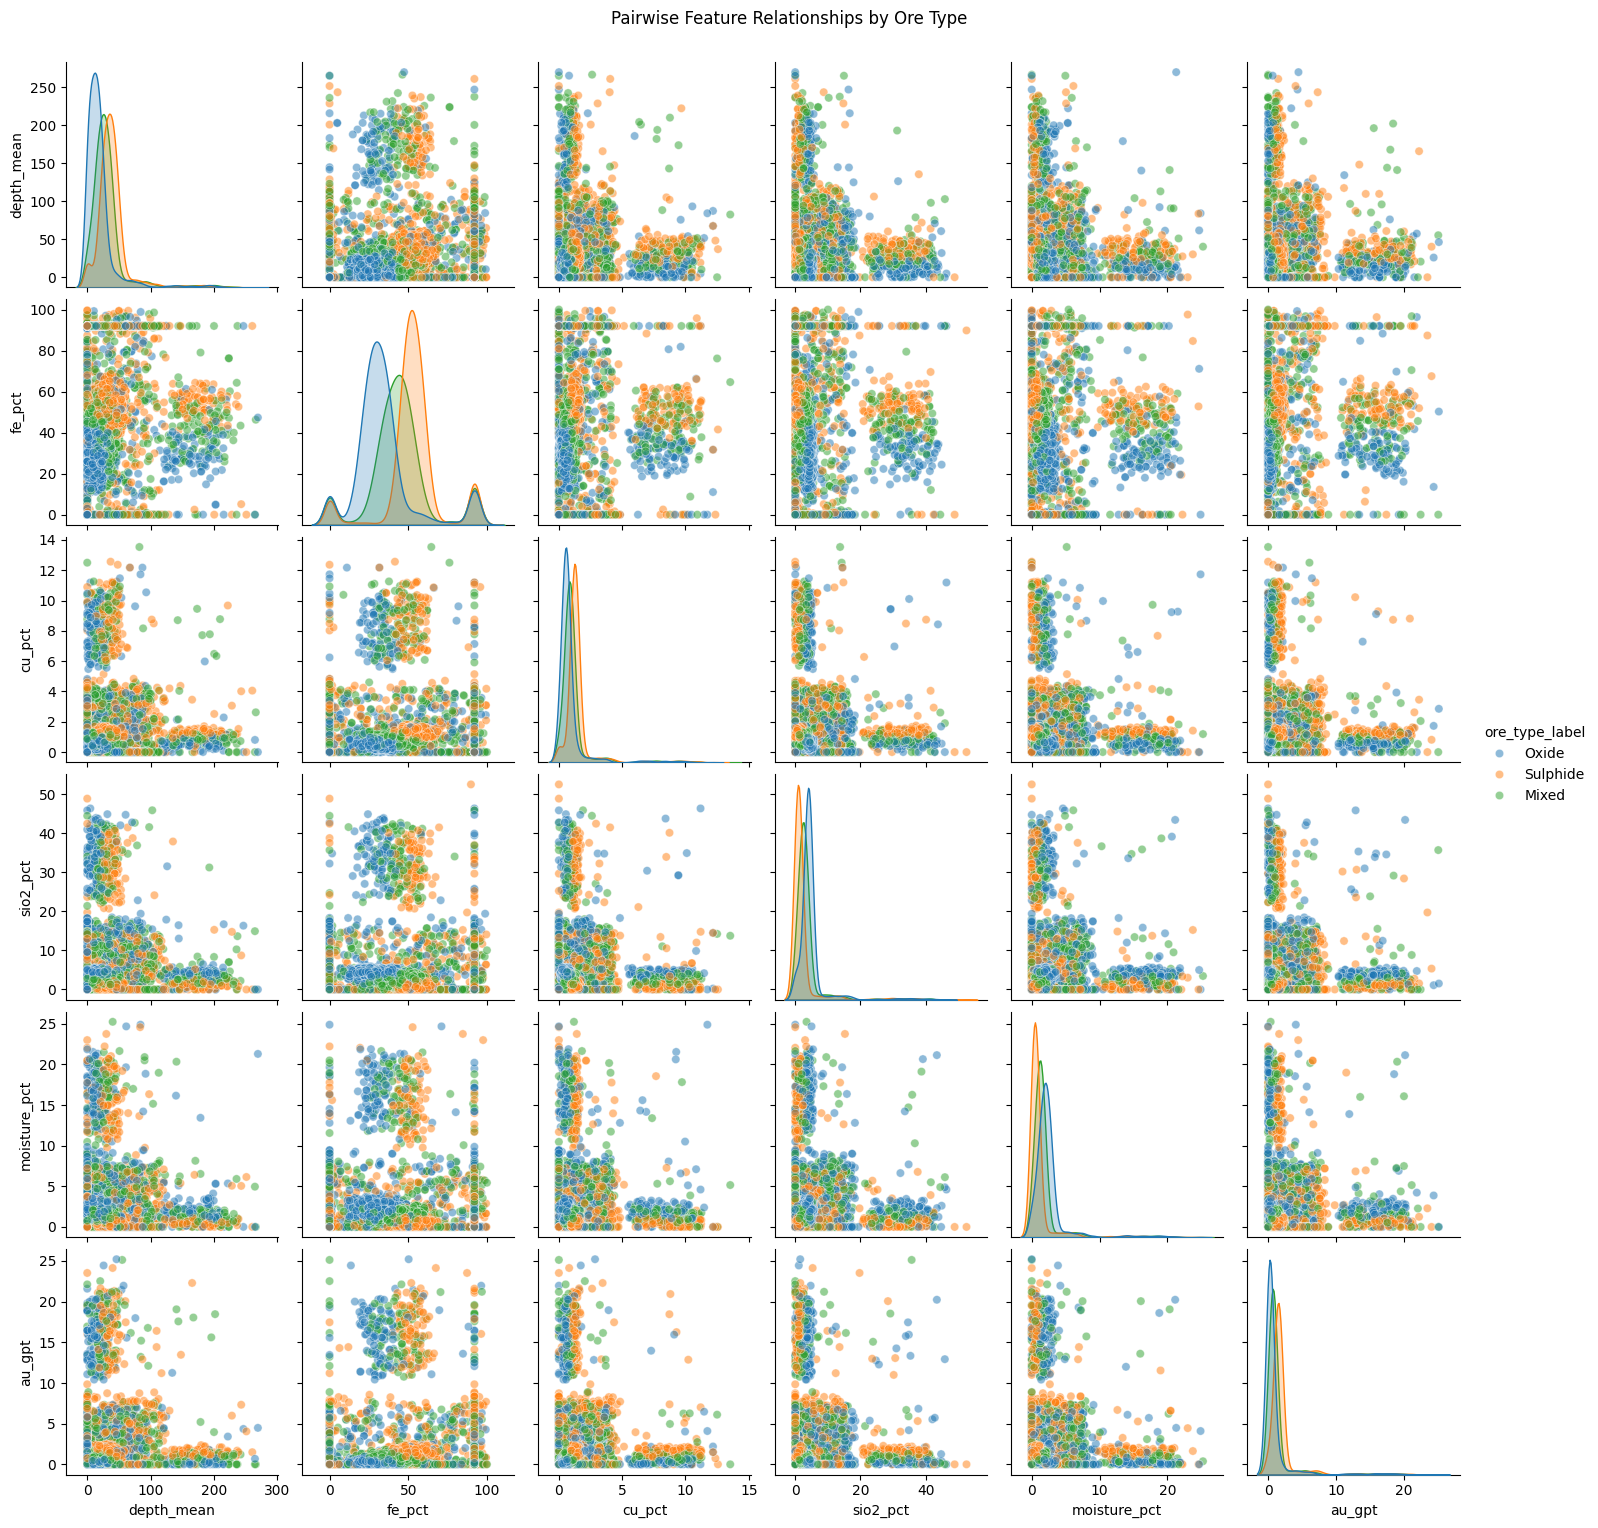


=== Highly Correlated Feature Pairs (>0.8) ===
depth_mean    fe_pct          0.114604
fe_pct        au_gpt          0.101344
              moisture_pct    0.094365
              cu_pct          0.073231
depth_mean    cu_pct          0.066403
fe_pct        sio2_pct        0.065633
sio2_pct      moisture_pct    0.063207
depth_mean    au_gpt          0.055065
              moisture_pct    0.044767
              sio2_pct        0.041585
cu_pct        au_gpt          0.040012
              moisture_pct    0.022546
              sio2_pct        0.017471
moisture_pct  au_gpt          0.010629
sio2_pct      au_gpt          0.003563
dtype: float64


In [186]:
# Pairplot by ore type
sns.pairplot(train_df, vars=numeric_features, hue='ore_type_label', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pairwise Feature Relationships by Ore Type', y=1.02)
plt.show()

# Correlation ranking
corr_matrix = train_df[numeric_features].corr().abs()
high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
print("\n=== Highly Correlated Feature Pairs (>0.8) ===")
print(high_corr.stack().sort_values(ascending=False))

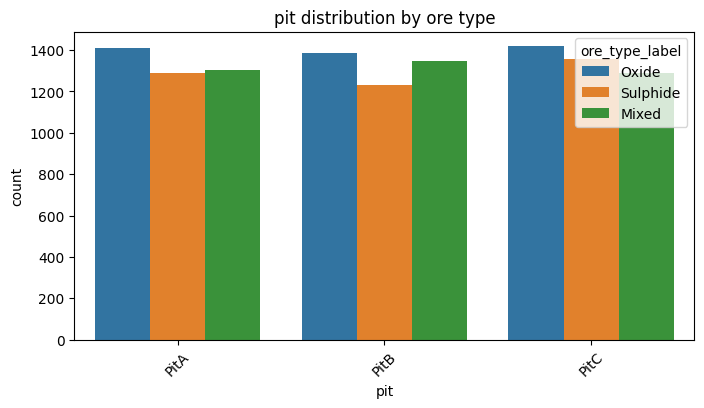

In [187]:
# Categorical feature distribution
categorical_features = ['pit']
for col in categorical_features:
    if col in train_df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(x=col, hue='ore_type_label', data=train_df)
        plt.title(f'{col} distribution by ore type')
        plt.xticks(rotation=45)
        plt.show()

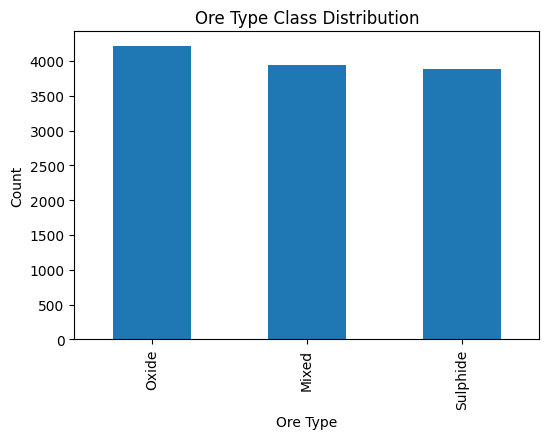

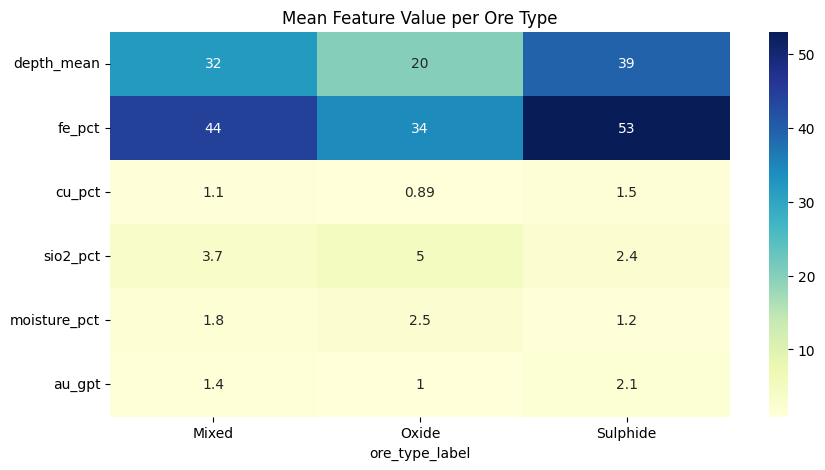


=== ANOVA Feature Importance (NaN handled by mean imputation) ===
        Feature     F_value        p_value  Significant
1        fe_pct  943.136344   0.000000e+00         True
0    depth_mean  409.996683  5.599767e-173         True
4  moisture_pct  215.962540   7.137667e-93         True
3      sio2_pct  198.619398   1.363350e-85         True
2        cu_pct  183.960867   2.015884e-79         True
5        au_gpt  147.385492   5.795712e-64         True


In [188]:
# Class balance
plt.figure(figsize=(6,4))
train_df['ore_type_label'].value_counts().plot(kind='bar')
plt.title('Ore Type Class Distribution')
plt.xlabel('Ore Type')
plt.ylabel('Count')
plt.show()

# Mean feature value per class
mean_per_class = train_df.groupby('ore_type_label')[numeric_features].mean().T
plt.figure(figsize=(10,5))
sns.heatmap(mean_per_class, annot=True, cmap='YlGnBu')
plt.title('Mean Feature Value per Ore Type')
plt.show()

# Feature importance proxy via ANOVA F-value
from sklearn.feature_selection import f_classif
# Handle NaN sebelum ANOVA dengan imputasi sederhana
X_anova = train_df[numeric_features].copy()
X_anova = X_anova.fillna(X_anova.mean())

f_values, p_values = f_classif(X_anova, train_df['ore_type_label'])
anova_df = pd.DataFrame({
    'Feature': numeric_features,
    'F_value': f_values,
    'p_value': p_values
})
anova_df['Significant'] = anova_df['p_value'] < 0.05

print("\n=== ANOVA Feature Importance (NaN handled by mean imputation) ===")
print(anova_df.sort_values('F_value', ascending=False))

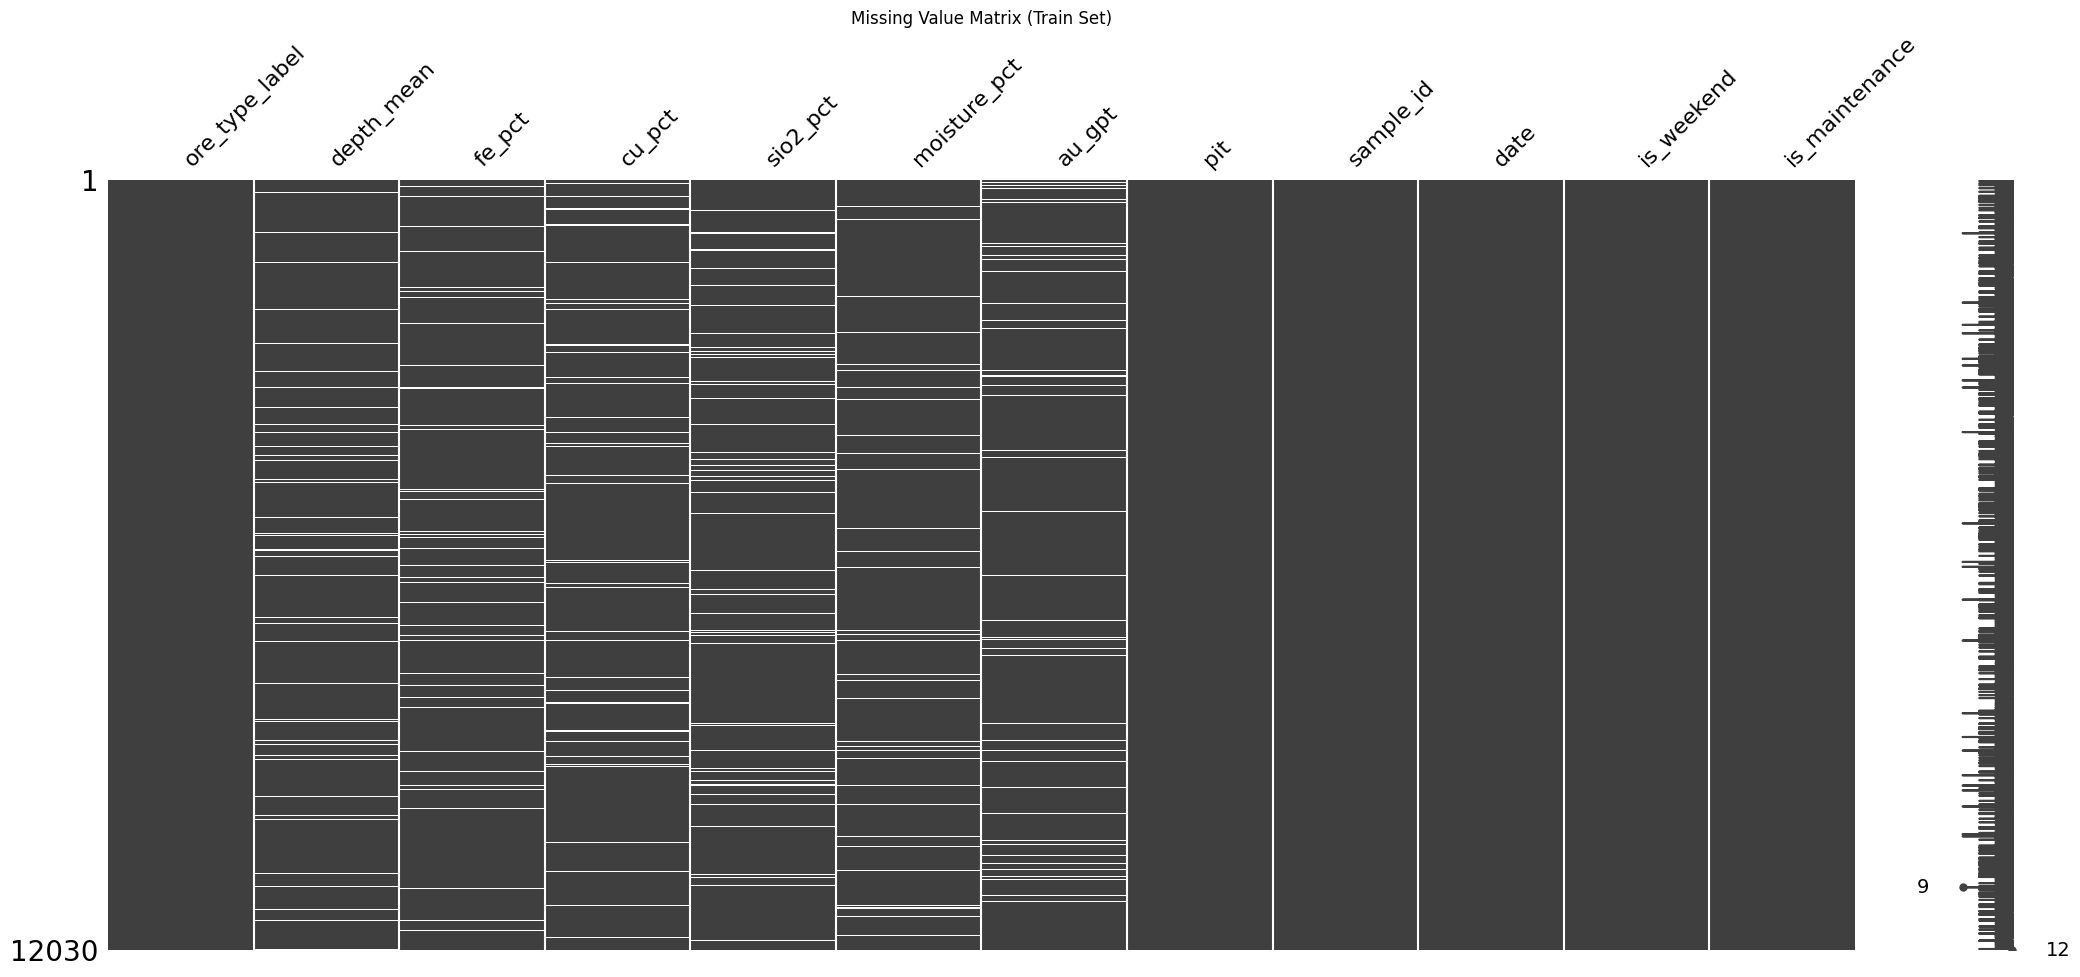

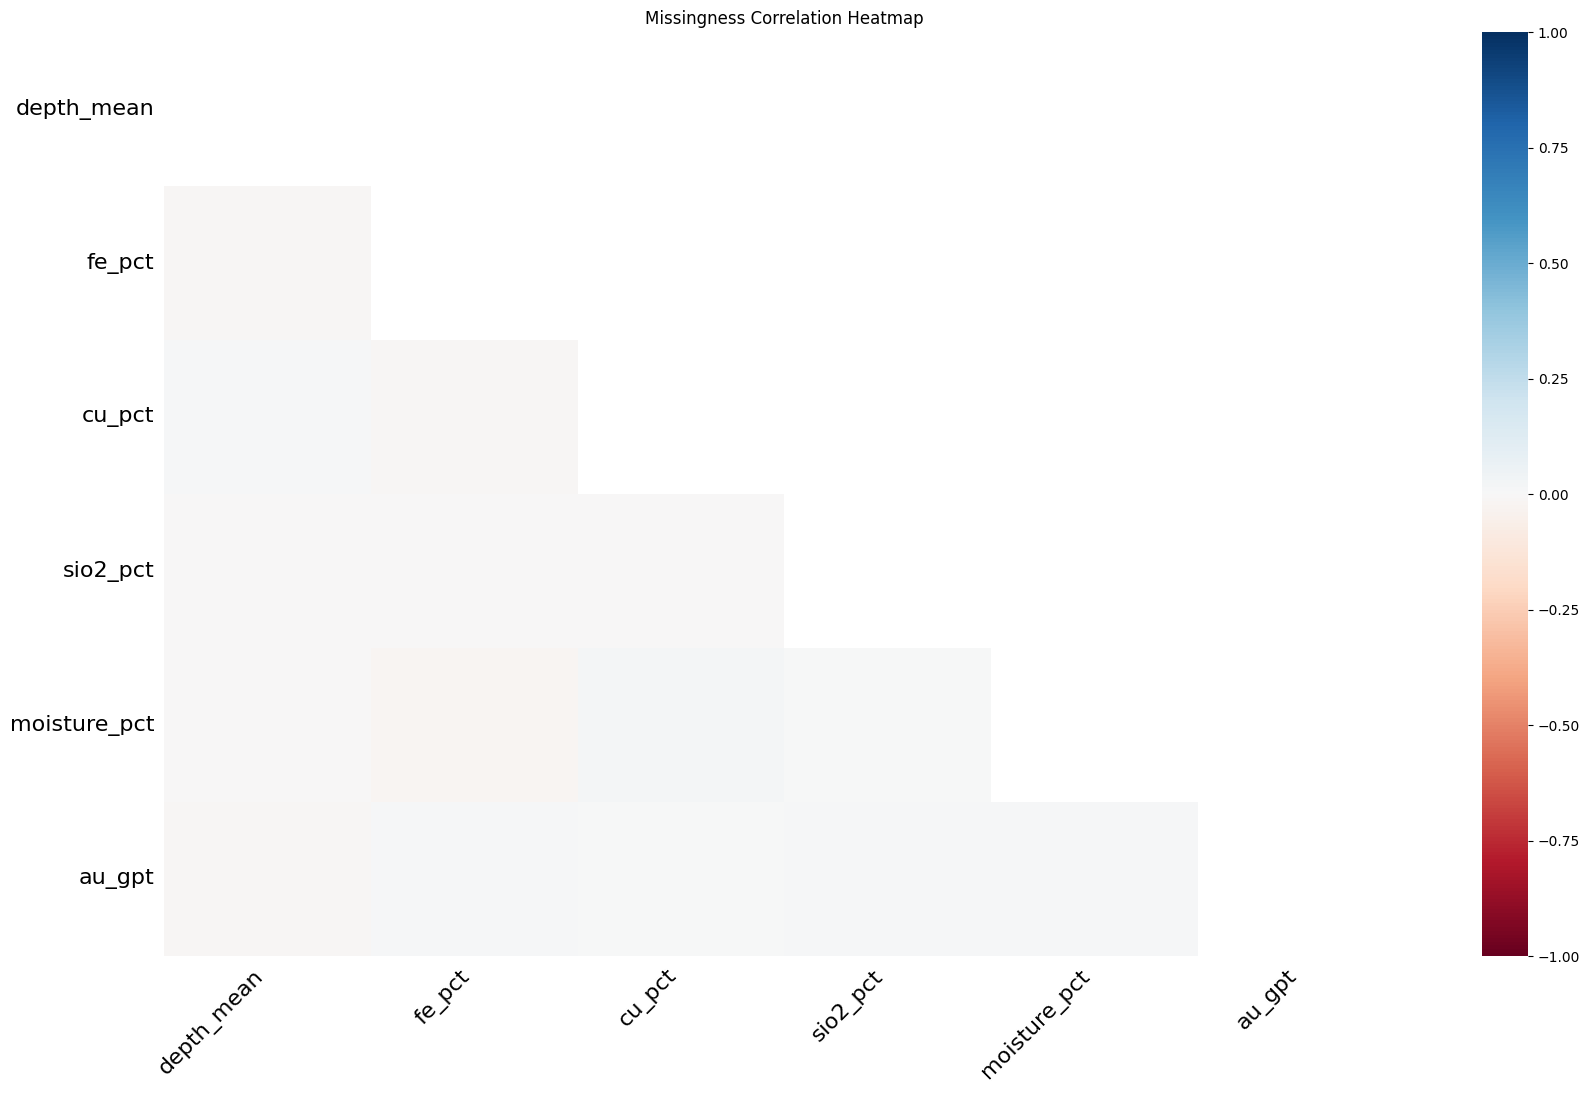

In [189]:
msno.matrix(train_df)
plt.title('Missing Value Matrix (Train Set)')
plt.show()

msno.heatmap(train_df)
plt.title('Missingness Correlation Heatmap')
plt.show()

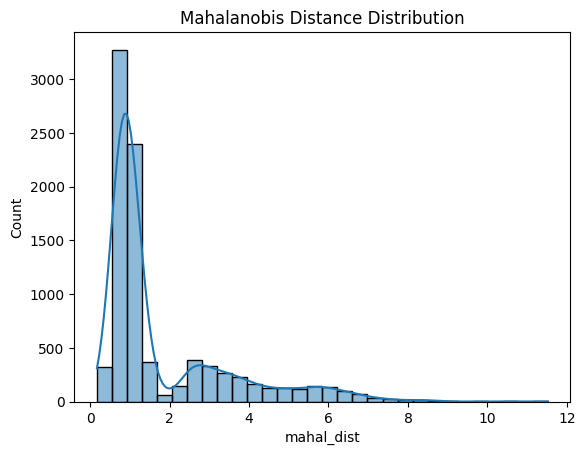


Potential Multivariate Outliers (>99th percentile): 89 samples


In [190]:
from scipy.spatial.distance import mahalanobis

X = train_df[numeric_features].dropna()
cov_matrix = np.cov(X.T)
inv_cov = np.linalg.inv(cov_matrix)
center = X.mean().values
mahal_dist = X.apply(lambda row: mahalanobis(row, center, inv_cov), axis=1)
train_df.loc[X.index, 'mahal_dist'] = mahal_dist

sns.histplot(train_df['mahal_dist'], bins=30, kde=True)
plt.title('Mahalanobis Distance Distribution')
plt.show()

# Threshold example (approx 99th percentile)
threshold = np.percentile(mahal_dist, 99)
potential_outliers = train_df[train_df['mahal_dist'] > threshold]
print(f"\nPotential Multivariate Outliers (>99th percentile): {len(potential_outliers)} samples")

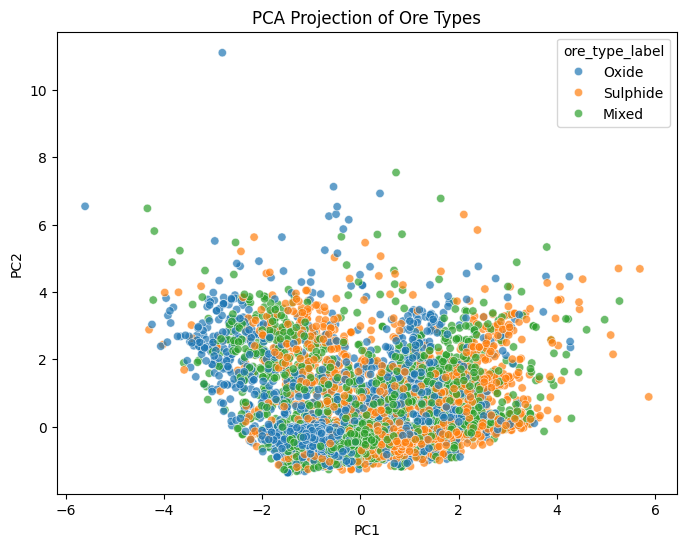

Explained variance ratio: 38.08%


In [191]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df[numeric_features].fillna(0))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['ore_type_label'] = train_df['ore_type_label'].values

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='ore_type_label', data=pca_df, alpha=0.7)
plt.title('PCA Projection of Ore Types')
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")


## Data Preprocessing

In [192]:
# =========================
# 1. Drop duplicates in train set
# =========================
from sklearn.calibration import LabelEncoder

train_df = train_df.drop_duplicates().reset_index(drop=True)

# =========================
# 2. Separate features and target (train)
# =========================
X_train = train_df.drop(['sample_id', 'ore_type_label'], axis=1)
y_train = train_df['ore_type_label']

# =========================
# 3. Encode target
# =========================
target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)

print("\nTarget mapping (train set):")
for cls, code in zip(target_encoder.classes_, range(len(target_encoder.classes_))):
    print(f"{cls} -> {code}")

# =========================
# 4. Identify numeric and categorical columns
# =========================
numeric_cols = ['depth_mean', 'fe_pct', 'cu_pct', 'sio2_pct', 'moisture_pct', 'au_gpt']
categorical_cols = ['pit']

# =========================
# 5. Preprocessing pipeline for train set
# =========================
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Fit on train set only
X_train_preprocessed = preprocessor.fit_transform(X_train)
print(f"\nShape of preprocessed train features: {X_train_preprocessed.shape}")

# =========================
# 6. Convert to DataFrame for inspection
# =========================
ohe_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_cols = numeric_cols + list(ohe_cols)

X_train_df = pd.DataFrame(X_train_preprocessed, columns=all_cols)

print("\nPreprocessed train features preview:")
print(X_train_df.head())
print("\nEncoded target (train) preview:")
print(y_train_encoded[:10])

# =========================
# 7. Apply same preprocessing to test set
# =========================
X_test = test_df.drop(['sample_id', 'ore_type_label'], axis=1)
# encode using same encoder (IMPORTANT: only use transform, not fit_transform)
y_test = target_encoder.transform(test_df['ore_type_label']) 
X_test_preprocessed = preprocessor.transform(X_test)

X_test_df = pd.DataFrame(X_test_preprocessed, columns=all_cols)
print(f"\nShape of preprocessed test features: {X_test_preprocessed.shape}")

print("\nEncoded target (test) preview:")
print(y_test[:10])


Target mapping (train set):
Mixed -> 0
Oxide -> 1
Sulphide -> 2

Shape of preprocessed train features: (12029, 9)

Preprocessed train features preview:
   depth_mean    fe_pct    cu_pct  sio2_pct  moisture_pct    au_gpt  pit_PitA   
0   -0.344295 -1.490408 -0.471831  0.217115     -0.000424 -0.309508       1.0  \
1   -0.403527  0.493542  0.014267 -0.446286     -0.554856  0.099700       0.0   
2   -0.983046 -2.175482  0.554094 -0.445677      0.033864 -0.515149       0.0   
3    1.310729  1.798330  1.856121 -0.651645     -0.654215 -0.515149       1.0   
4   -0.241974  0.456985 -0.165412 -0.263900     -0.230706 -0.068908       0.0   

   pit_PitB  pit_PitC  
0       0.0       0.0  
1       1.0       0.0  
2       0.0       1.0  
3       0.0       0.0  
4       0.0       1.0  

Encoded target (train) preview:
[1 2 1 1 2 2 1 2 0 0]

Shape of preprocessed test features: (3008, 9)

Encoded target (test) preview:
[0 1 1 1 2 1 1 0 0 1]


## Modelling


EVALUASI MODEL: Random Forest

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       844     82        58
Oxide        94    870        90
Sulphide     93     26       851

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.82      0.86      0.84       984
       Oxide       0.89      0.83      0.86      1054
    Sulphide       0.85      0.88      0.86       970

    accuracy                           0.85      3008
   macro avg       0.85      0.85      0.85      3008
weighted avg       0.85      0.85      0.85      3008

ROC AUC Score (One-vs-Rest): 0.9602


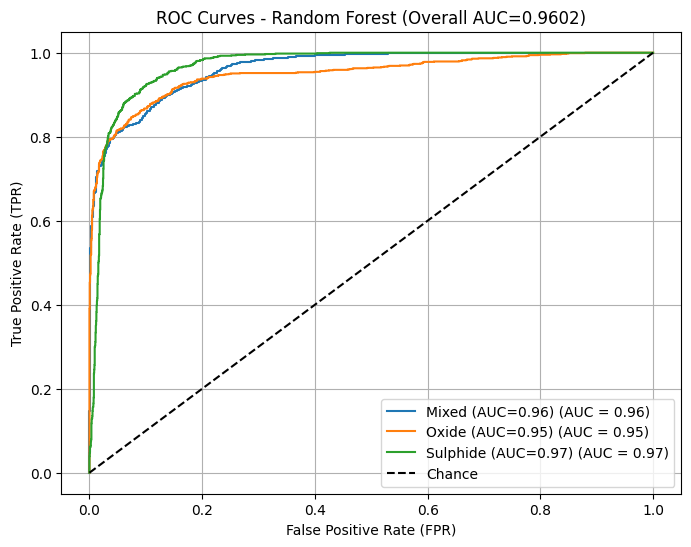


EVALUASI MODEL: Decision Tree

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       790    125        69
Oxide       122    844        88
Sulphide    101     54       815

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.78      0.80      0.79       984
       Oxide       0.83      0.80      0.81      1054
    Sulphide       0.84      0.84      0.84       970

    accuracy                           0.81      3008
   macro avg       0.81      0.81      0.81      3008
weighted avg       0.81      0.81      0.81      3008

ROC AUC Score (One-vs-Rest): 0.8905


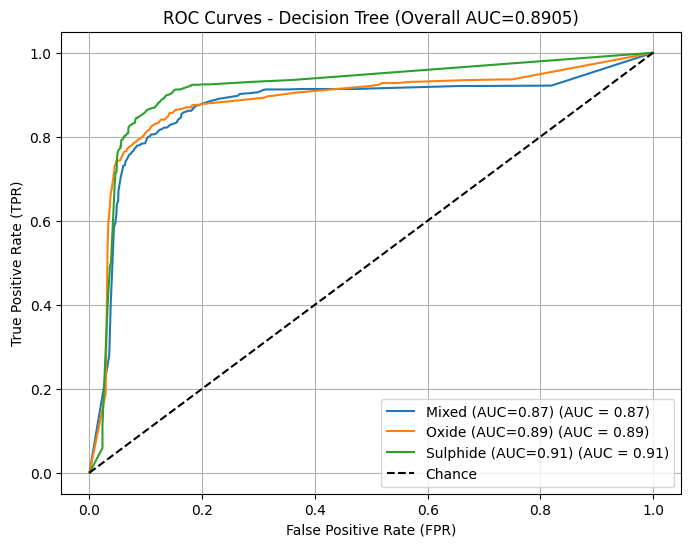


EVALUASI MODEL: Logistic Regression

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       187    494       303
Oxide        34    835       185
Sulphide     33     96       841

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.74      0.19      0.30       984
       Oxide       0.59      0.79      0.67      1054
    Sulphide       0.63      0.87      0.73       970

    accuracy                           0.62      3008
   macro avg       0.65      0.62      0.57      3008
weighted avg       0.65      0.62      0.57      3008

ROC AUC Score (One-vs-Rest): 0.7373


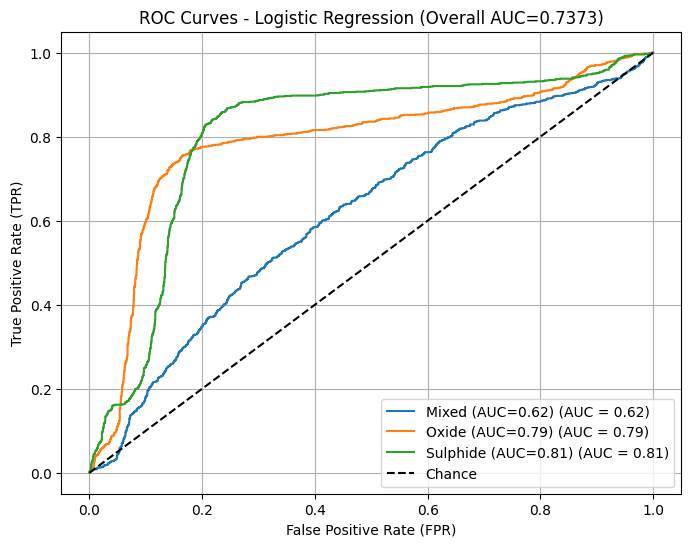


EVALUASI MODEL: KNN

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       779    134        71
Oxide       126    848        80
Sulphide    113     40       817

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.77      0.79      0.78       984
       Oxide       0.83      0.80      0.82      1054
    Sulphide       0.84      0.84      0.84       970

    accuracy                           0.81      3008
   macro avg       0.81      0.81      0.81      3008
weighted avg       0.81      0.81      0.81      3008

ROC AUC Score (One-vs-Rest): 0.9311


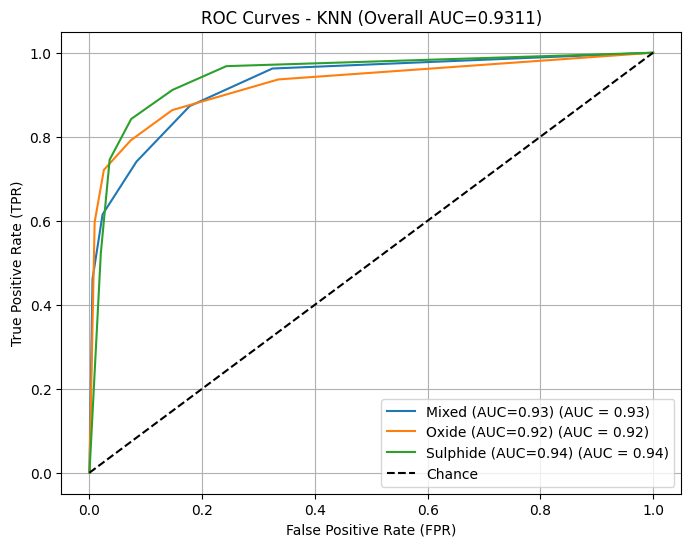

In [193]:
# List of models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='ovr', solver='liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Binarizer for multi-class ROC
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
n_classes = y_test_binarized.shape[1]
class_names = target_encoder.classes_

for model_name, model in models.items():
    print("\n" + "="*50)
    print(f"EVALUASI MODEL: {model_name}")
    print("="*50)

    # Pipeline: preprocessing + classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Latih model
    pipeline.fit(X_train, y_train_encoded)

    # Prediksi
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, index=class_names, columns=class_names))

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # ROC AUC
    roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')
    print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")

    # ROC curve visualization
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        y_score = y_proba[:, i]
        RocCurveDisplay.from_predictions(
            y_test_binarized[:, i],
            y_score,
            name=f"{class_names[i]} (AUC={roc_auc_score(y_test_binarized[:, i], y_score):.2f})",
            ax=plt.gca()
        )
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f'ROC Curves - {model_name} (Overall AUC={roc_auc:.4f})')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

Model Random Search Progress:   0%|          | 0/4 [00:00<?, ?it/s]


RANDOMIZED SEARCH & EVALUASI MODEL: Random Forest

Best Parameters for Random Forest:
{'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 15}
Best CV ROC AUC: 0.9620
Model saved successfully: models\best_model_random_forest.pkl

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       842     80        62
Oxide        98    870        86
Sulphide     90     31       849

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.82      0.86      0.84       984
       Oxide       0.89      0.83      0.86      1054
    Sulphide       0.85      0.88      0.86       970

    accuracy                           0.85      3008
   macro avg       0.85      0.85      0.85      3008
weighted avg       0.85      0.85      0.85      3008

Test ROC AUC (One-vs-Rest): 0.9616


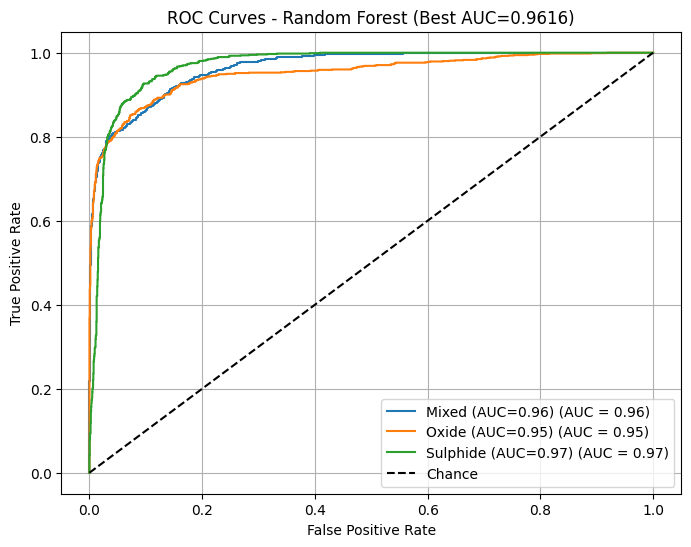

Model Random Search Progress:  25%|██▌       | 1/4 [12:26<37:20, 746.93s/it]


RANDOMIZED SEARCH & EVALUASI MODEL: Decision Tree

Best Parameters for Decision Tree:
{'classifier__min_samples_split': 10, 'classifier__max_depth': 5, 'classifier__criterion': 'log_loss'}
Best CV ROC AUC: 0.9159
Model saved successfully: models\best_model_decision_tree.pkl

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       761    138        85
Oxide       135    826        93
Sulphide    164     26       780

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.72      0.77      0.74       984
       Oxide       0.83      0.78      0.81      1054
    Sulphide       0.81      0.80      0.81       970

    accuracy                           0.79      3008
   macro avg       0.79      0.79      0.79      3008
weighted avg       0.79      0.79      0.79      3008

Test ROC AUC (One-vs-Rest): 0.9138


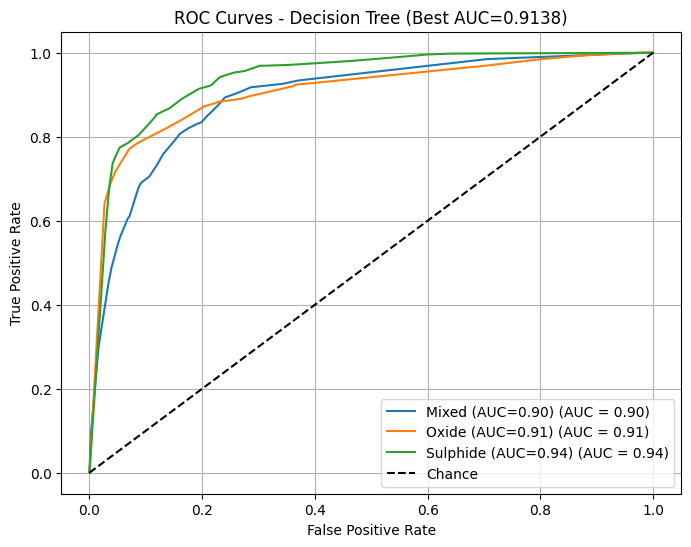

Model Random Search Progress:  50%|█████     | 2/4 [12:42<10:33, 316.83s/it]


RANDOMIZED SEARCH & EVALUASI MODEL: Logistic Regression

Best Parameters for Logistic Regression:
{'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 0.0774263682681127}
Best CV ROC AUC: 0.7520
Model saved successfully: models\best_model_logistic_regression.pkl

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       176    502       306
Oxide        30    837       187
Sulphide     32     96       842

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.74      0.18      0.29       984
       Oxide       0.58      0.79      0.67      1054
    Sulphide       0.63      0.87      0.73       970

    accuracy                           0.62      3008
   macro avg       0.65      0.61      0.56      3008
weighted avg       0.65      0.62      0.57      3008

Test ROC AUC (One-vs-Rest): 0.7384


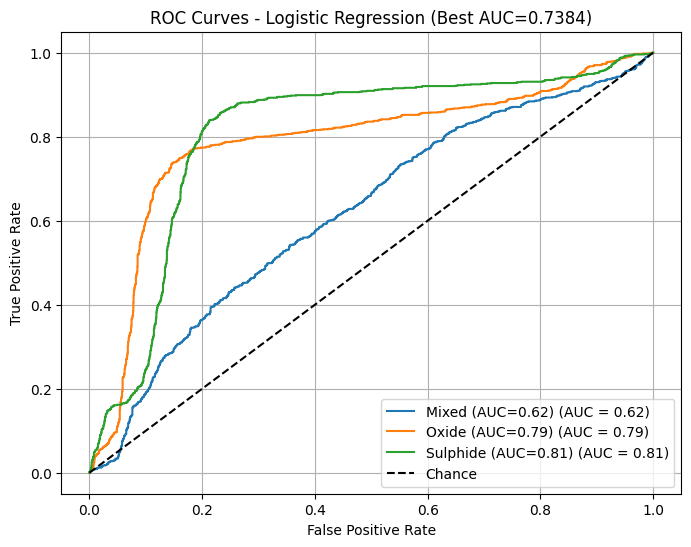

Model Random Search Progress:  75%|███████▌  | 3/4 [12:48<02:54, 174.73s/it]


RANDOMIZED SEARCH & EVALUASI MODEL: KNN

Best Parameters for KNN:
{'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 11}
Best CV ROC AUC: 0.9472
Model saved successfully: models\best_model_knn.pkl

Confusion Matrix:
          Mixed  Oxide  Sulphide
Mixed       774    120        90
Oxide        89    876        89
Sulphide     77     37       856

Classification Report:
              precision    recall  f1-score   support

       Mixed       0.82      0.79      0.80       984
       Oxide       0.85      0.83      0.84      1054
    Sulphide       0.83      0.88      0.85       970

    accuracy                           0.83      3008
   macro avg       0.83      0.83      0.83      3008
weighted avg       0.83      0.83      0.83      3008

Test ROC AUC (One-vs-Rest): 0.9487


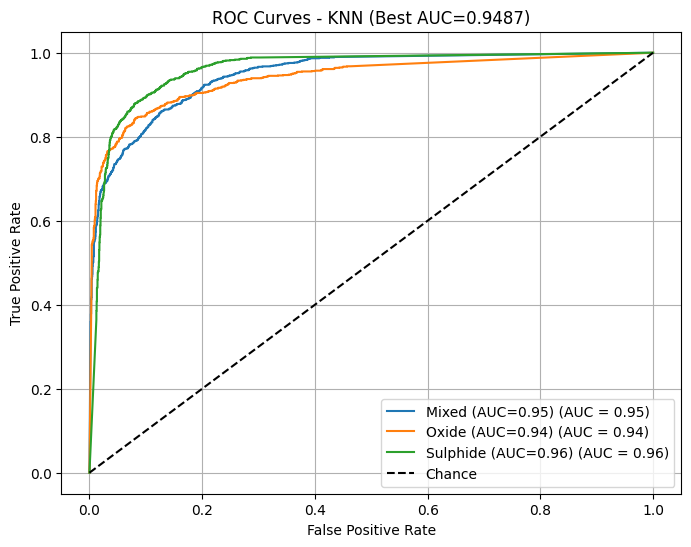

Model Random Search Progress: 100%|██████████| 4/4 [13:04<00:00, 196.12s/it]


In [194]:
from sklearn.model_selection import RandomizedSearchCV
import os

# =====================================
# Hyperparameter grids
# =====================================
param_dists = {
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [5, 10, 15, 20, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'Decision Tree': {
        'classifier__max_depth': [5, 10, 15, 20, None],
        'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Logistic Regression': {
        'classifier__C': np.logspace(-2, 2, 10),
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9, 11],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    }
}

# =====================================
# CV strategy & container
# =====================================
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_summary = []

# =====================================
# RandomizedSearchCV Loop
# =====================================
for model_name, model in tqdm(models.items(), desc="Model Random Search Progress", position=0):
    print("\n" + "="*70)
    print(f"RANDOMIZED SEARCH & EVALUASI MODEL: {model_name}")
    print("="*70)

    # Pipeline: preprocessing + classifier
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Randomized Search setup
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dists[model_name],
        n_iter=15,                        # reduce for speed
        scoring='roc_auc_ovr',
        cv=cv_strategy,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    # Fit on training data
    random_search.fit(X_train, y_train_encoded)

    print(f"\nBest Parameters for {model_name}:")
    print(random_search.best_params_)
    print(f"Best CV ROC AUC: {random_search.best_score_:.4f}")

    # --- Save best model to models/ directory ---
    best_model = random_search.best_estimator_

    # Pastikan folder 'models' ada
    os.makedirs('models', exist_ok=True)

    # Tentukan nama file model
    model_filename = f"best_model_{model_name.replace(' ', '_').lower()}.pkl"
    model_path = os.path.join('models', model_filename)

    # Simpan model ke file
    with open(model_path, 'wb') as f:
        pickle.dump(best_model, f)

    print(f"Model saved successfully: {model_path}")

    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, index=target_encoder.classes_, columns=target_encoder.classes_))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

    # ROC AUC
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)
    roc_auc = roc_auc_score(y_test_binarized, y_proba, multi_class='ovr')
    print(f"Test ROC AUC (One-vs-Rest): {roc_auc:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(target_encoder.classes_):
        RocCurveDisplay.from_predictions(
            y_test_binarized[:, i],
            y_proba[:, i],
            name=f"{cls} (AUC={roc_auc_score(y_test_binarized[:, i], y_proba[:, i]):.2f})",
            ax=plt.gca()
        )
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title(f'ROC Curves - {model_name} (Best AUC={roc_auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Append results
    results_summary.append({
        'Model': model_name,
        'Best_Params': random_search.best_params_,
        'CV_ROC_AUC': random_search.best_score_,
        'Test_ROC_AUC': roc_auc
    })

In [195]:
# =====================================
# Summary Comparison Table
# =====================================
summary_df = pd.DataFrame(results_summary)
summary_df = summary_df.sort_values(by='Test_ROC_AUC', ascending=False).round(4)

print("\n=== SUMMARY COMPARISON ===")
summary_df


=== SUMMARY COMPARISON ===


Model                                        Best_Params   
0        Random Forest  {'classifier__n_estimators': 300, 'classifier_...  \
3                  KNN  {'classifier__weights': 'distance', 'classifie...   
1        Decision Tree  {'classifier__min_samples_split': 10, 'classif...   
2  Logistic Regression  {'classifier__solver': 'liblinear', 'classifie...   

   CV_ROC_AUC  Test_ROC_AUC  
0      0.9620        0.9616  
3      0.9472        0.9487  
1      0.9159        0.9138  
2      0.7520        0.7384

## Cost Evaluation

Saran tindakan selanjutnya (konkrit)
- Tentukan apa yang lebih mahal: salah prediksi sulphide→oxide atau oxide→sulphide? Kuantifikasi (Rp/ton) jika mungkin.
- Isi cost_matrix dengan nilai ekonomi nyata; gunakan metric custom itu untuk memilih model.
- Kalau kelas minor (mis. sulphide) penting → optimalkan recall untuk kelas tersebut, tapi pantau precision agar false alarms tak menenggelamkan operasi.
- Simpan semua metrik tiap eksperimen (MLflow/W&B) agar bisa trade-off explicit antar model.

Asumsi domain (ringkas)
- Sulphide = umumnya higher-value → kehilangan klasifikasi ini mahal (lost revenue & recovery drop).
- Oxide = umumnya lower-value, tapi jika diproses seperti sulphide akan menambah biaya energi + reagent (over-processing).
- Mixed = di tengah; baik under- maupun over-treatment punya biaya sedang.
- Contoh angka asumsi: harga/penalty per ton dan biaya pengolahan digambarkan bulat untuk kemudahan (Rp).

Contoh kuantifikasi (Rp/ton) — interpretasi cepat
- Under-treating sulphide → oxide: sangat mahal (lost revenue + recovery) → Rp 450.000 / ton
- Under-treating sulphide → mixed: kurang parah tapi masih mahal → Rp 200.000 / ton
- Over-treating oxide → sulphide: biaya energi + reagent + handling → Rp 180.000 / ton
- Over-treating oxide → mixed: biaya sedang → Rp 120.000 / ton
- Mixed misclassifications: moderate (over or under) → Rp 60.000–80.000 / ton

In [196]:
classes = ["mixed", "sulphide", "oxide"]
label_to_idx = {lab: i for i, lab in enumerate(classes)}

# Cost matrix in Rp/ton (row=true, col=pred)
cost_matrix = np.array([
    [0,       80_000,  60_000],   # true = mixed
    [200_000,     0,   450_000],  # true = sulphide
    [120_000, 180_000,      0]    # true = oxide
])

def compute_avg_cost(y_true, y_pred, cost_matrix, label_to_idx):
    idx_true = np.array([label_to_idx[t] for t in y_true])
    idx_pred = np.array([label_to_idx[p] for p in y_pred])
    costs = cost_matrix[idx_true, idx_pred]
    return costs.mean(), costs.sum()  # rata-rata Rp/ton, total Rp

# Contoh pemakaian
y_true = ["sulphide","oxide","mixed","sulphide","oxide"]
y_pred = ["oxide","oxide","sulphide","mixed","mixed"]

avg_cost, total_cost = compute_avg_cost(y_true, y_pred, cost_matrix, label_to_idx)
print(f"Avg penalty (Rp/ton): {avg_cost:,.0f}")
print(f"Total penalty (Rp): {total_cost:,.0f}")


Avg penalty (Rp/ton): 170,000
Total penalty (Rp): 850,000


Rekomendasi & trade-offs (kritis)

- Jangan pakai angka ini apa adanya untuk keputusan produksi. Angka harus dikalibrasi ke: harga concentrate, recovery impact per ton, biaya energi & reagent, dan kontrak off-taker.
- Lakukan sensitivity analysis: jalankan eksperimen dengan skenario low/medium/high penalty (mis. ±30%) untuk lihat stabilitas pemilihan model.
- Jika misclassification sulphide sangat mahal → prioritaskan recall untuk sulphide (bisa set class_weight atau thresholding probabilitas). Tapi hati-hati: meningkatkan recall bisa meningkatkan false positives → biaya over-processing. It’s a trade-off ekonomi.
- Simpan asumsi dan metadata (unit Rp/ton, periode, sumber angka) bersama model (mis. di MLflow) supaya keputusan dapat diaudit.
- Pertimbangkan menghitung biaya per-batch (ton × Rp/ton) karena operasi biasanya berjalan batch/shift.

In [9]:
# Hitung persentase kelas ore_type_label per hari (3 kolom: mixed, oxide, sulphide)
# Menggunakan dataset yang sudah ada dan kolom 'date' (datetime)

# Pastikan kolom tanggal hanya tanggal (tanpa jam)
dataset['date'] = pd.to_datetime(dataset['date']).dt.date

# Hitung jumlah per hari per kelas, lalu ubah ke persentase
counts_per_day = dataset.groupby(['date', 'ore_type_label']).size().unstack(fill_value=0)

# Pastikan urutan kolom dan isi semua kelas (jika suatu hari tidak ada kelas, beri 0)
for cls in ['Mixed', 'Oxide', 'Sulphide']:
    if cls not in counts_per_day.columns:
        counts_per_day[cls] = 0
counts_per_day = counts_per_day[['Mixed', 'Oxide', 'Sulphide']]

pct_per_day = counts_per_day.div(counts_per_day.sum(axis=1), axis=0) * 100

# Ubah nama kolom ke lowercase sesuai permintaan (mixed, oxide, sulphide)
pct_per_day = pct_per_day.rename(columns=lambda c: c.lower()).reset_index()

# Tampilkan hasil (head)
pct_per_day.head()

print(pct_per_day.shape)

(752, 4)


In [10]:
pct_per_day.tail()

ore_type_label        date      mixed      oxide   sulphide
747             2025-01-17   0.000000  65.000000  35.000000
748             2025-01-18  25.000000  35.000000  40.000000
749             2025-01-19  35.000000  45.000000  20.000000
750             2025-01-20  30.000000  25.000000  45.000000
751             2025-01-21  22.222222  38.888889  38.888889

In [15]:
pct_per_day['date'] = pd.to_datetime(pct_per_day['date'])

# Data Generating Process Tonnage

In [208]:
# 1. Date range harian 2 tahun
dates = pd.date_range(start="2023-01-01", end="2025-01-21", freq='D')
n = len(dates)

# 2. Random seed
np.random.seed(42)

# 3. Trend (misal +0.5 t per hari)
trend = np.linspace(10000, 12000, n)  # mulai 10k t/day → 12k t/day setelah 2 tahun

# 4. Musiman mingguan (shift / hari kerja vs weekend)
weekly_seasonality = 500 * np.sin(2 * np.pi * np.arange(n) / 7)  # ±500 t fluktuasi mingguan

# 5. Musiman tahunan (maintenance, curah hujan, dll)
annual_seasonality = 800 * np.sin(2 * np.pi * np.arange(n) / 365.25)  # ±800 t per tahun

# 6. Noise besar (realistis)
noise = np.random.normal(0, 1000, n)  # std dev 1000 t

# 7. Holiday effect (misal shutdown tertentu)
holidays = ['2023-01-01','2023-12-25','2024-01-01','2024-12-25']  # contoh
holiday_effect = np.array([ -2000 if d.strftime('%Y-%m-%d') in holidays else 0 for d in dates])

# 8. Dummy tonnage = trend + seasonality + noise + holiday
tonnage = trend + weekly_seasonality + annual_seasonality + noise + holiday_effect
tonnage = np.round(tonnage).astype(int)  # integer tonnage

# 11. Build DataFrame
df = pd.DataFrame({
        'date': dates,
        'tonnage': tonnage,
})

# 12. Tampilkan contoh
df.to_csv('simulated_tonnage.csv', index=False)

In [11]:
df_tonnage = pd.read_csv('data/simulated_tonnage.csv', parse_dates=['date'])

In [12]:
df_tonnage.head()

date  tonnage
0 2023-01-01     8497
1 2023-01-02    10269
2 2023-01-03    11168
3 2023-01-04    11789
4 2023-01-05     9615

In [17]:
df_pct_tonnage = pd.merge(pct_per_day, df_tonnage, on='date', how='left')

02:39:11 - cmdstanpy - INFO - Chain [1] start processing
02:39:11 - cmdstanpy - INFO - Chain [1] done processing


Test periods: 90
RMSE: 1,011.41
MAPE: 7.51%


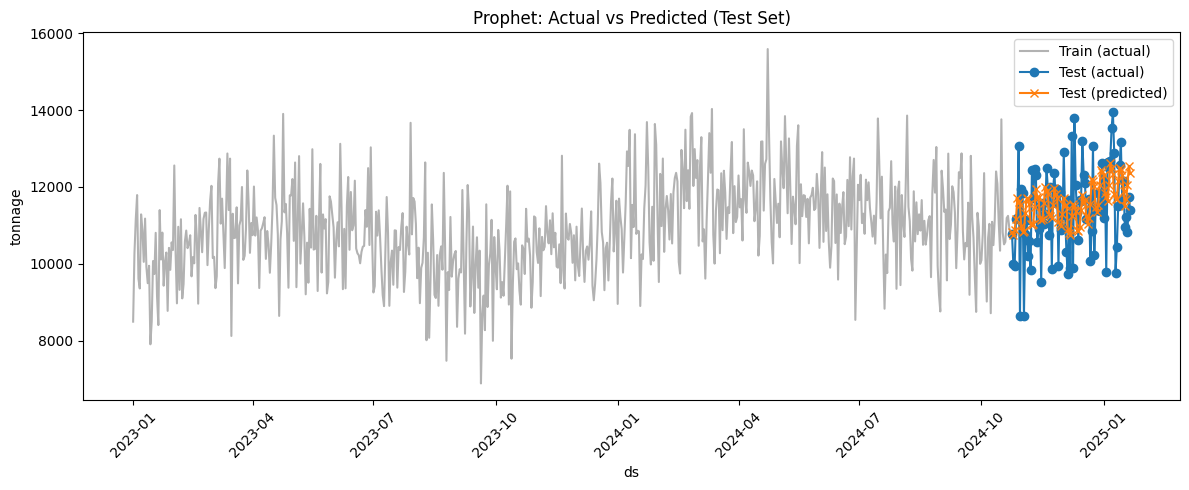

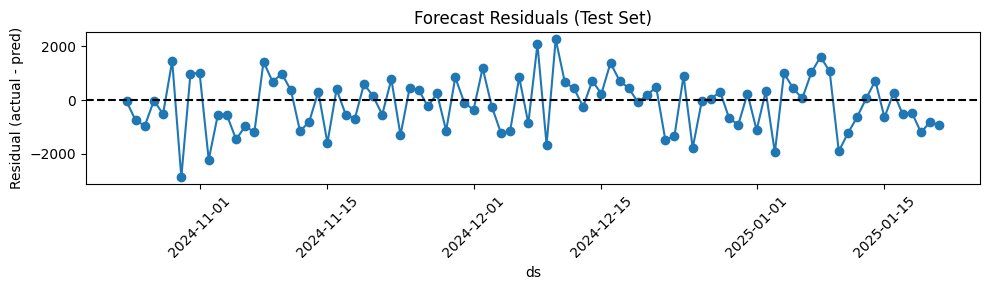

In [ ]:
prophet_df = df_pct_tonnage.rename(columns={
    'date': 'ds',
    'tonnage': 'y'
})

# Train/test split for Prophet and compute RMSE & MAPE
test_periods = 90  # adjust as needed

# Ensure sorted
prophet_df = prophet_df.sort_values('ds').reset_index(drop=True)

if test_periods >= len(prophet_df):
    raise ValueError("test_periods is >= number of observations. Reduce test_periods.")

# Split
train_df = prophet_df.iloc[:-test_periods].copy()
test_df = prophet_df.iloc[-test_periods:].copy()

# Regressors present in prophet_df (exclude 'ds' and 'y')
regressors = [c for c in prophet_df.columns if c not in ['ds','y']]

# Build and fit Prophet with regressors (if any)
from prophet import Prophet

m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, seasonality_mode='additive')
for r in regressors:
    m.add_regressor(r)

m.fit(train_df[['ds','y'] + regressors])

# Predict on test set (must supply regressors for test ds)
pred = m.predict(test_df[['ds'] + regressors])

# Align actuals and predictions
y_true = test_df['y'].values
y_pred = pred['yhat'].values

# Metrics: RMSE and MAPE (handle zeros in y_true)
import numpy as np
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
nonzero_mask = y_true != 0
if nonzero_mask.sum() == 0:
    mape = np.nan
else:
    mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

print(f"Test periods: {len(y_true)}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs predicted for test period
plt.figure(figsize=(12,5))
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Test (actual)', marker='o')
plt.plot(test_df['ds'], y_pred, label='Test (predicted)', marker='x')
plt.xlabel('ds')
plt.ylabel('tonnage')
plt.title('Prophet: Actual vs Predicted (Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Inspect residuals
residuals = y_true - y_pred
plt.figure(figsize=(10,3))
plt.plot(test_df['ds'], residuals, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ds')
plt.ylabel('Residual (actual - pred)')
plt.title('Forecast Residuals (Test Set)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
df_pct_tonnage.columns

Index(['date', 'mixed', 'oxide', 'sulphide', 'tonnage'], dtype='object')

02:53:49 - cmdstanpy - INFO - Chain [1] start processing
02:53:49 - cmdstanpy - INFO - Chain [1] done processing


Test periods: 90
RMSE: 10.36
MAPE: 25.33%


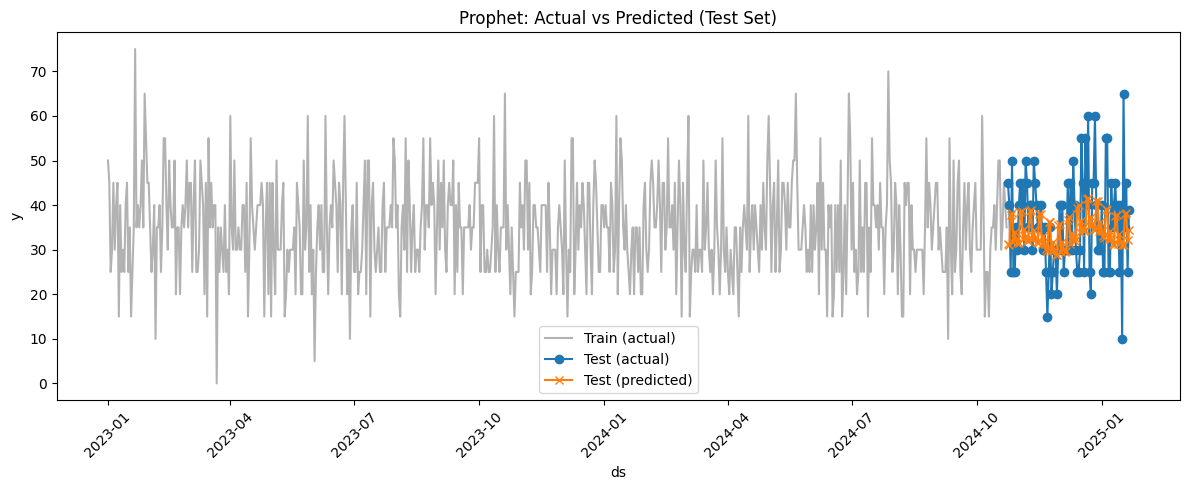

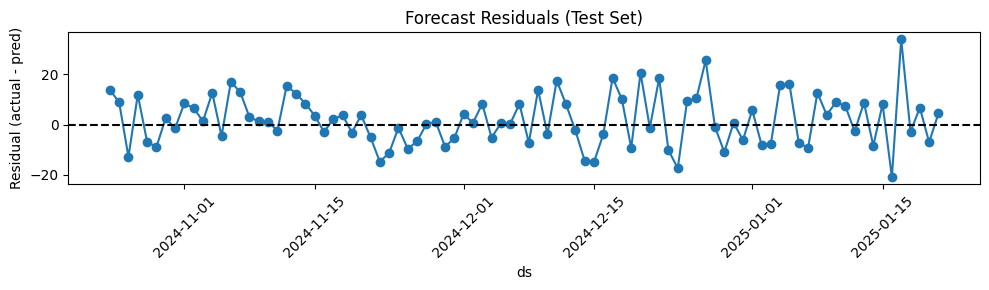

In [28]:
# Prepare univariate dataframe
prophet_pct_oxide_df = df_pct_tonnage.rename(columns={'date': 'ds', 'oxide': 'y'})

# Ensure sorted
prophet_pct_oxide_df = prophet_pct_oxide_df.sort_values('ds').reset_index(drop=True)

# Train/test split
test_periods = 90

if test_periods >= len(prophet_pct_oxide_df):
    raise ValueError("test_periods is >= number of observations. Reduce test_periods.")

train_df = prophet_pct_oxide_df.iloc[:-test_periods].copy()
test_df = prophet_pct_oxide_df.iloc[-test_periods:].copy()

# Initialize Prophet without regressors
m = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=False, 
    seasonality_mode='additive'
)

# Fit on training data
m.fit(train_df[['ds', 'y']])

# Forecast
pred = m.predict(test_df[['ds']])

# Align actuals and predictions
y_true = test_df['y'].values
y_pred = pred['yhat'].values

# Metrics: RMSE and MAPE
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
nonzero_mask = y_true != 0
mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

print(f"Test periods: {len(y_true)}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Test (actual)', marker='o')
plt.plot(test_df['ds'], y_pred, label='Test (predicted)', marker='x')
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Prophet: Actual vs Predicted (Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_true - y_pred

plt.figure(figsize=(10, 3))
plt.plot(test_df['ds'], residuals, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ds')
plt.ylabel('Residual (actual - pred)')
plt.title('Forecast Residuals (Test Set)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

02:53:51 - cmdstanpy - INFO - Chain [1] start processing
02:53:52 - cmdstanpy - INFO - Chain [1] done processing


Test periods: 90
RMSE: 11.70
MAPE: 39.51%


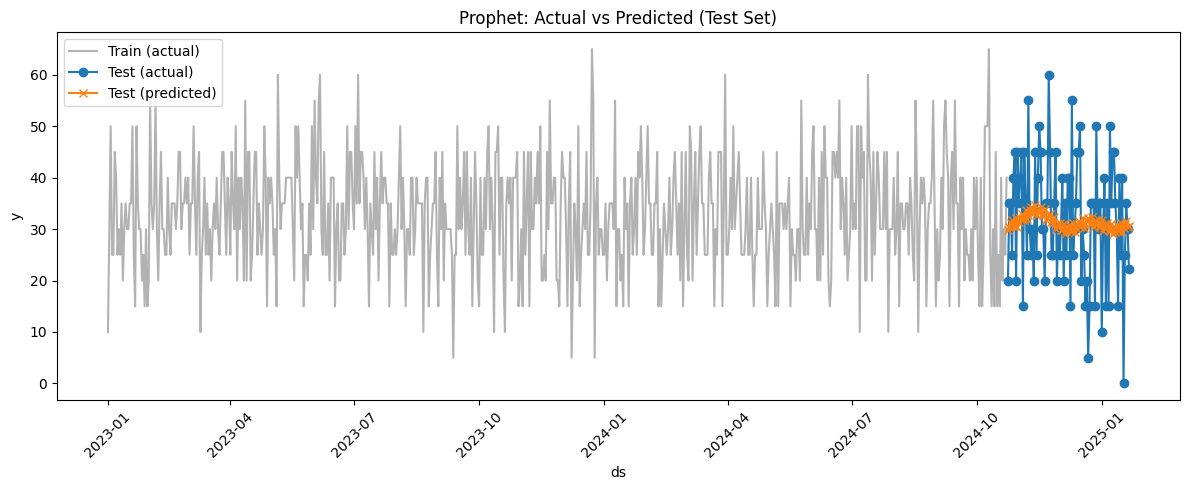

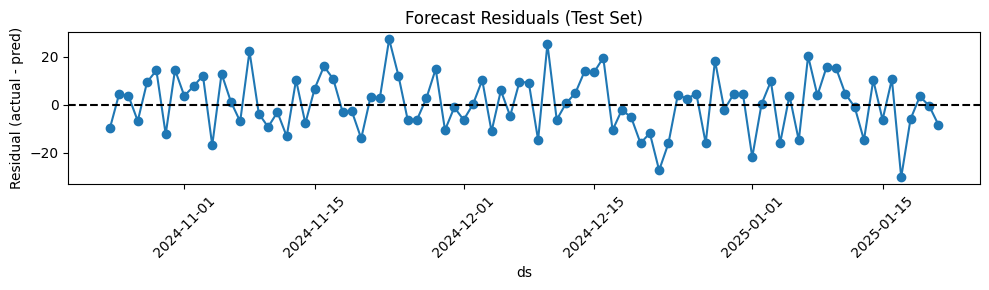

In [29]:
# Prepare univariate dataframe
prophet_pct_mixed_df = df_pct_tonnage.rename(columns={'date': 'ds', 'mixed': 'y'})

# Ensure sorted
prophet_pct_mixed_df = prophet_pct_mixed_df.sort_values('ds').reset_index(drop=True)

# Train/test split
test_periods = 90

if test_periods >= len(prophet_pct_mixed_df):
    raise ValueError("test_periods is >= number of observations. Reduce test_periods.")

train_df = prophet_pct_mixed_df.iloc[:-test_periods].copy()
test_df = prophet_pct_mixed_df.iloc[-test_periods:].copy()

# Initialize Prophet without regressors
m = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=False, 
    seasonality_mode='additive'
)

# Fit on training data
m.fit(train_df[['ds', 'y']])

# Forecast
pred = m.predict(test_df[['ds']])

# Align actuals and predictions
y_true = test_df['y'].values
y_pred = pred['yhat'].values

# Metrics: RMSE and MAPE
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
nonzero_mask = y_true != 0
mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

print(f"Test periods: {len(y_true)}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Test (actual)', marker='o')
plt.plot(test_df['ds'], y_pred, label='Test (predicted)', marker='x')
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Prophet: Actual vs Predicted (Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_true - y_pred

plt.figure(figsize=(10, 3))
plt.plot(test_df['ds'], residuals, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ds')
plt.ylabel('Residual (actual - pred)')
plt.title('Forecast Residuals (Test Set)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

02:53:58 - cmdstanpy - INFO - Chain [1] start processing
02:53:58 - cmdstanpy - INFO - Chain [1] done processing


Test periods: 90
RMSE: 11.84
MAPE: 43.80%


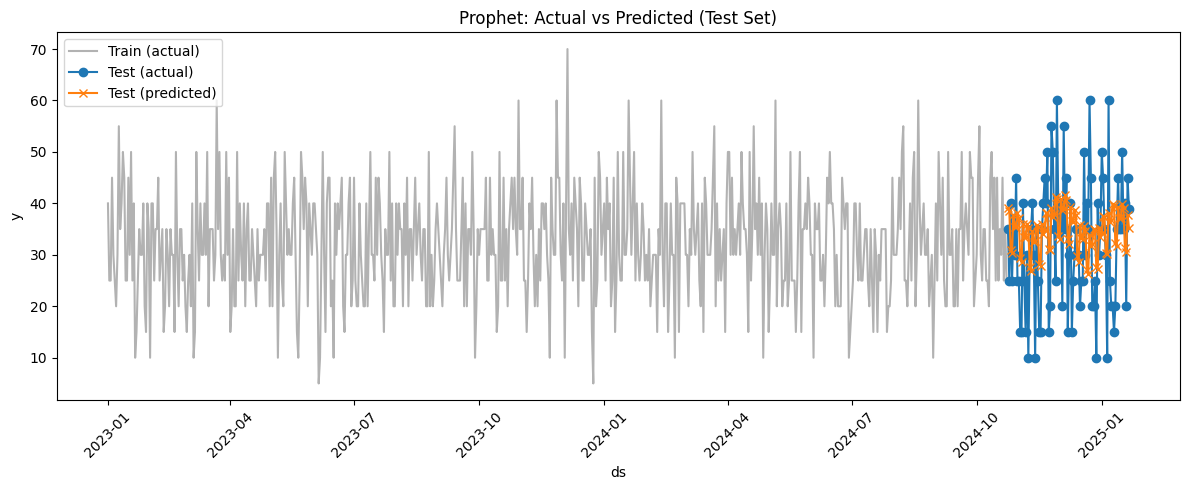

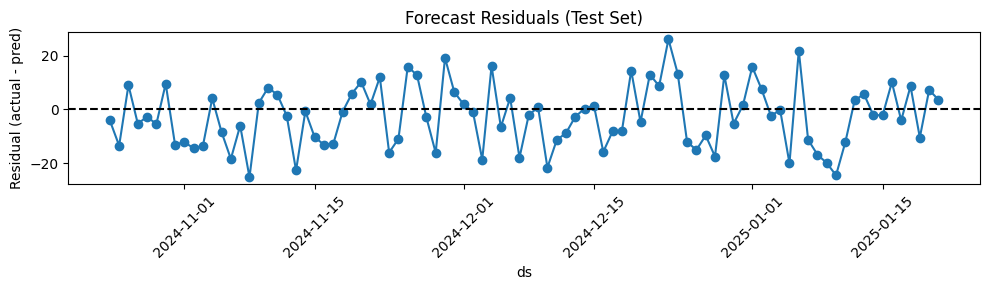

In [30]:
# Prepare univariate dataframe
prophet_pct_sulphide_df = df_pct_tonnage.rename(columns={'date': 'ds', 'sulphide': 'y'})

# Ensure sorted
prophet_pct_sulphide_df = prophet_pct_sulphide_df.sort_values('ds').reset_index(drop=True)

# Train/test split
test_periods = 90

if test_periods >= len(prophet_pct_sulphide_df):
    raise ValueError("test_periods is >= number of observations. Reduce test_periods.")

train_df = prophet_pct_sulphide_df.iloc[:-test_periods].copy()
test_df = prophet_pct_sulphide_df.iloc[-test_periods:].copy()

# Initialize Prophet without regressors
m = Prophet(
    yearly_seasonality=True, 
    weekly_seasonality=True, 
    daily_seasonality=False, 
    seasonality_mode='additive'
)

# Fit on training data
m.fit(train_df[['ds', 'y']])

# Forecast
pred = m.predict(test_df[['ds']])

# Align actuals and predictions
y_true = test_df['y'].values
y_pred = pred['yhat'].values

# Metrics: RMSE and MAPE
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
nonzero_mask = y_true != 0
mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

print(f"Test periods: {len(y_true)}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(train_df['ds'], train_df['y'], label='Train (actual)', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Test (actual)', marker='o')
plt.plot(test_df['ds'], y_pred, label='Test (predicted)', marker='x')
plt.xlabel('ds')
plt.ylabel('y')
plt.title('Prophet: Actual vs Predicted (Test Set)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_true - y_pred

plt.figure(figsize=(10, 3))
plt.plot(test_df['ds'], residuals, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('ds')
plt.ylabel('Residual (actual - pred)')
plt.title('Forecast Residuals (Test Set)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
df_pct_tonnage.head()

date  mixed  oxide  sulphide  tonnage
0 2023-01-01   10.0   50.0      40.0     8497
1 2023-01-02   30.0   45.0      25.0    10269
2 2023-01-03   50.0   25.0      25.0    11168
3 2023-01-04   25.0   30.0      45.0    11789
4 2023-01-05   25.0   45.0      30.0     9615

In [34]:
# Hitung tonnage per ore type
df_pct_tonnage['sulphide_ton'] = df_pct_tonnage['sulphide'] * df_pct_tonnage['tonnage']/100
df_pct_tonnage['oxide_ton'] = df_pct_tonnage['oxide'] * df_pct_tonnage['tonnage']/100
df_pct_tonnage['mixed_ton'] = df_pct_tonnage['mixed'] * df_pct_tonnage['tonnage']/100

# Hitung biaya/revenue impact
df_pct_tonnage['Cost_impact_Rp'] = (
    df_pct_tonnage['sulphide_ton'] * 500 +
    df_pct_tonnage['oxide_ton'] * 0 +
    df_pct_tonnage['mixed_ton'] * 250
)

# Hitung energy usage
df_pct_tonnage['Energy_kWh'] = (
    df_pct_tonnage['sulphide_ton'] * 1.2 +
    df_pct_tonnage['oxide_ton'] * 1.0 +
    df_pct_tonnage['mixed_ton'] * 1.1
)

# Hitung deviasi jika proporsi berbeda dari target
target_sulphide = 0.45
df_pct_tonnage['sulphide_dev_ton'] = (df_pct_tonnage['sulphide'] - target_sulphide) * df_pct_tonnage['tonnage']
df_pct_tonnage['Deviation_cost_Rp'] = df_pct_tonnage['sulphide_dev_ton'] * 500

df_pct_tonnage[['date','sulphide','oxide','mixed','sulphide_ton','Cost_impact_Rp','Energy_kWh','Deviation_cost_Rp']]


date   sulphide      oxide      mixed  sulphide_ton  Cost_impact_Rp   
0   2023-01-01  40.000000  50.000000  10.000000       3398.80       1911825.0  \
1   2023-01-02  25.000000  45.000000  30.000000       2567.25       2053800.0   
2   2023-01-03  25.000000  25.000000  50.000000       2792.00       2792000.0   
3   2023-01-04  45.000000  30.000000  25.000000       5305.05       3389337.5   
4   2023-01-05  30.000000  45.000000  25.000000       2884.50       2043187.5   
..         ...        ...        ...        ...           ...             ...   
747 2025-01-17  35.000000  65.000000   0.000000       3839.85       1919925.0   
748 2025-01-18  40.000000  35.000000  25.000000       4490.80       2947087.5   
749 2025-01-19  20.000000  45.000000  35.000000       2167.60       2032125.0   
750 2025-01-20  45.000000  25.000000  30.000000       5277.60       3518400.0   
751 2025-01-21  38.888889  38.888889  22.222222       4438.00       2853000.0   

     Energy_kWh  Deviation_cost_Rp  
0      9261.730        168028175.0  
1     11090.520        126051975.0  
2     12284.800        137087200.0  
3     13144.735        262599975.0  
4     10432.275        142061625.0  
..          ...                ...  
747   11738.970        189524025.0  
748   12405.835        222013925.0  
749   11650.850        105941450.0  
750   13135.360        261241200.0  
751   12553.200        219332300.0  

[752 rows x 8 columns]

In [ ]:
# -----------------------------
# 2️⃣ Dummy Dataset 2 (Shift-Level Aggregation)
# -----------------------------
n_shifts = 200
shift_start_dates = pd.date_range(start='2025-11-01', periods=n_shifts, freq='8H')

dataset2 = pd.DataFrame({
    'shift_id': np.tile([1,2,3], n_shifts//3 + 1)[:n_shifts],
    'shift_start': shift_start_dates,
    'prob_sulphide': np.random.uniform(0.4, 0.9, n_shifts),
    'prob_oxide': np.random.uniform(0.1, 0.5, n_shifts),
    'prob_mixed': np.random.uniform(0.0, 0.2, n_shifts),
    'avg_mill_load': np.random.uniform(60, 90, n_shifts),
    'avg_solids_pct': np.random.uniform(35, 50, n_shifts),
    'avg_cyclone_pressure': np.random.uniform(100, 200, n_shifts),
    'feed_tonnage': np.random.uniform(1000, 1500, n_shifts),
    'pct_tonnage_from_PitA': np.random.uniform(0.3, 0.7, n_shifts),
    'rain_mm_last_24h': np.random.uniform(0, 10, n_shifts)
})

# -----------------------------
# 3️⃣ Dummy Dataset 3 (Prophet-ready)
# -----------------------------
dataset3 = dataset2.copy()
dataset3.rename(columns={'shift_start':'ds'}, inplace=True)

# Simulasi mill throughput (y) sebagai fungsi linear + noise dari regressor
dataset3['y'] = (dataset3['prob_sulphide']*0.5 + 
                 dataset3['prob_oxide']*0.3 + 
                 dataset3['avg_mill_load']*0.05 + 
                 dataset3['feed_tonnage']*0.001 + 
                 np.random.normal(0, 0.05, n_shifts)) * 1000  # scale ke ton/shift

# Dataset siap Prophet
prophet_dataset = dataset3[['ds','y','prob_sulphide','prob_oxide','prob_mixed',
                            'avg_mill_load','avg_solids_pct','avg_cyclone_pressure',
                            'feed_tonnage','pct_tonnage_from_PitA','rain_mm_last_24h']]

# Tampilkan head
print(prophet_dataset.head())

                   ds            y  prob_sulphide  prob_oxide  prob_mixed   
0 2025-11-01 00:00:00  5201.219804       0.738926    0.183930    0.149708  \
1 2025-11-01 08:00:00  6114.355508       0.484496    0.242781    0.012701   
2 2025-11-01 16:00:00  5087.012259       0.752401    0.413025    0.037146   
3 2025-11-02 00:00:00  4951.722307       0.770717    0.357505    0.083392   
4 2025-11-02 08:00:00  5570.574473       0.843440    0.230510    0.092530   

   avg_mill_load  avg_solids_pct  avg_cyclone_pressure  feed_tonnage   
0      64.802285       37.534709            105.809665   1483.240830  \
1      87.220093       46.832326            105.984719   1444.320516   
2      65.413702       42.563298            137.060140   1397.267101   
3      61.213023       42.690719            119.496396   1347.378758   
4      77.628770       40.431683            193.478079   1287.077773   

   pct_tonnage_from_PitA  rain_mm_last_24h  
0               0.588230          2.147900  
1             

In [23]:
dataset1.head()

sample_id   pit  depth_mean     fe_pct    cu_pct  sio2_pct  moisture_pct   
0     S0000  PitC    4.579104  39.693019  0.830528  1.668883      1.739211  \
1     S0001  PitA   45.865679  43.091161  0.701281  2.896567      2.001111   
2     S0002  PitC    6.840932  54.623086  0.773487  4.445003      2.734731   
3     S0003  PitC   47.511868  59.229574  0.935929  2.846525      1.036861   
4     S0004  PitA   22.300289        NaN  0.493641  3.158612      1.864522   

     au_gpt ore_type_label  
0  1.955987       Sulphide  
1  1.988576          Oxide  
2  1.111234       Sulphide  
3  0.340285          Oxide  
4  0.632210       Sulphide

In [24]:
dataset1.isna().sum()

sample_id          0
pit                0
depth_mean        76
fe_pct            76
cu_pct            80
sio2_pct          78
moisture_pct      78
au_gpt            77
ore_type_label     0
dtype: int64

In [11]:
dataset2.head()

shift_id         shift_start  prob_sulphide  prob_oxide  prob_mixed   
0         1 2025-11-01 00:00:00       0.590572    0.287241    0.097938  \
1         2 2025-11-01 08:00:00       0.866406    0.396207    0.022087   
2         3 2025-11-01 16:00:00       0.757582    0.433002    0.094317   
3         1 2025-11-02 00:00:00       0.864123    0.400316    0.048765   
4         2 2025-11-02 08:00:00       0.798487    0.157546    0.069819   

   avg_mill_load  avg_solids_pct  avg_cyclone_pressure  feed_tonnage   
0      74.254415       45.604954            193.073940   1360.734769  \
1      72.650449       39.266305            157.851179   1275.168249   
2      73.331551       39.008705            117.896182   1393.065211   
3      61.359939       48.188736            166.369514   1141.327826   
4      70.848490       37.437187            199.076216   1091.956026   

   pct_tonnage_from_PitA  rain_mm_last_24h  
0               0.636486          1.711113  
1               0.438356          9.308731  
2               0.547213          5.306881  
3               0.495837          9.229278  
4               0.686866          2.077301

In [13]:
dataset3.head()

shift_id                  ds  prob_sulphide  prob_oxide  prob_mixed   
0         1 2025-11-01 00:00:00       0.590572    0.287241    0.097938  \
1         2 2025-11-01 08:00:00       0.866406    0.396207    0.022087   
2         3 2025-11-01 16:00:00       0.757582    0.433002    0.094317   
3         1 2025-11-02 00:00:00       0.864123    0.400316    0.048765   
4         2 2025-11-02 08:00:00       0.798487    0.157546    0.069819   

   avg_mill_load  avg_solids_pct  avg_cyclone_pressure  feed_tonnage   
0      74.254415       45.604954            193.073940   1360.734769  \
1      72.650449       39.266305            157.851179   1275.168249   
2      73.331551       39.008705            117.896182   1393.065211   
3      61.359939       48.188736            166.369514   1141.327826   
4      70.848490       37.437187            199.076216   1091.956026   

   pct_tonnage_from_PitA  rain_mm_last_24h            y  
0               0.636486          1.711113  5477.221400  
1               0.438356          9.308731  5518.302466  
2               0.547213          5.306881  5567.645292  
3               0.495837          9.229278  4722.364004  
4               0.686866          2.077301  5070.344484